# Galaxies vs Quasars
### Time to get your hands dirty. Galaxy vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

Some figures from the second paper:

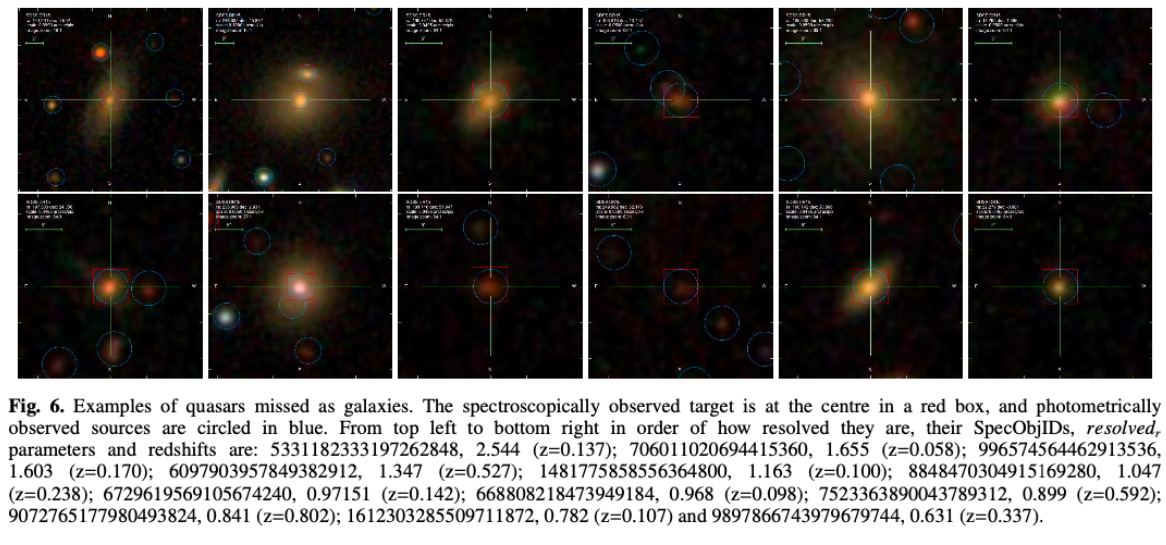

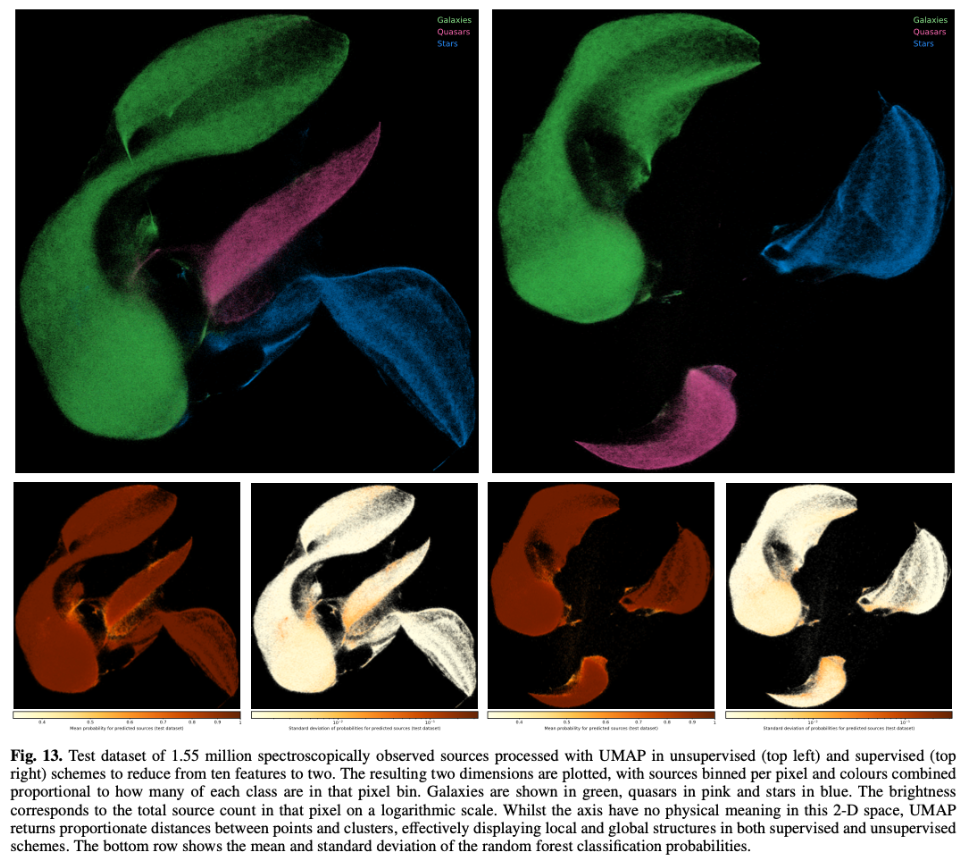

In [1]:
from IPython.display import Image, display
display(Image(filename='../../Images/Gal vs Quasars I.png'))
display(Image(filename='../../Images/Gal vs Quasars II.png'))

SDSS observed in four bands:
    
![](https://speclite.readthedocs.io/en/latest/_images/sdss2010.png) 
    

#### Data

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used [SQL](https://en.wikipedia.org/wiki/SQL) and want to learn something new it's computing, it's very powerful)

#### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

#### Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?


In [2]:
import emcee
import corner
import numpy as np
from scipy import stats
from astropy.table import Table
import pandas as pd

from astroML.utils import completeness_contamination
from astroML.utils.decorators import pickle_results
from astroML.utils import split_samples
from astroML.classification import GMMBayes
from astroML.resample import bootstrap

import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Fetching and visualizing the data

In [3]:
data = pd.read_csv('../solutions/galaxyquasar.csv')

data

u         g         r         i         z   class        z1  \
0      18.97213  18.53676  18.58280  18.34936  18.29215     QSO  0.522819   
1      19.24592  17.47646  16.47817  16.04472  15.68851  GALAXY  0.122846   
2      19.43536  17.70268  16.91565  16.58327  16.39128  GALAXY  0.000000   
3      19.31626  18.18312  17.39591  16.94549  16.65395  GALAXY  0.147435   
4      19.28828  19.11188  18.88937  18.80013  18.49183     QSO  2.011455   
...         ...       ...       ...       ...       ...     ...       ...   
49995  19.37295  18.12382  17.39886  16.98503  16.70585  GALAXY  0.113016   
49996  18.52021  16.88262  16.03280  15.56884  15.22454  GALAXY  0.085063   
49997  18.62718  17.30876  16.87371  16.62399  16.42296  GALAXY  0.054429   
49998  19.55140  18.27711  17.62101  17.21947  17.03347  GALAXY  0.112571   
49999  18.80772  17.75751  17.40500  17.21650  17.12295  GALAXY  0.043652   

           zerr  
0      0.000155  
1      0.000028  
2      0.000000  
3      0.000009  
4      0.000631  
...         ...  
49995  0.000011  
49996  0.000014  
49997  0.000008  
49998  0.000009  
49999  0.000007  

[50000 rows x 8 columns]

In [4]:
u_g = np.array(data['u']-data['g'])
g_r = np.array(data['g']-data['r'])
r_i = np.array(data['r']-data['i'])
i_z = np.array(data['i']-data['z'])

labels = data['class']

In [5]:
ND_dataset = np.array([u_g, g_r, r_i, i_z]).T
labels_01  = np.where(labels=='QSO', 1, 0)    # 1=QSO, 0=GALAXY
legends    = ['u-g', 'g-r', 'r-i', 'i-z']

### Corner Plot

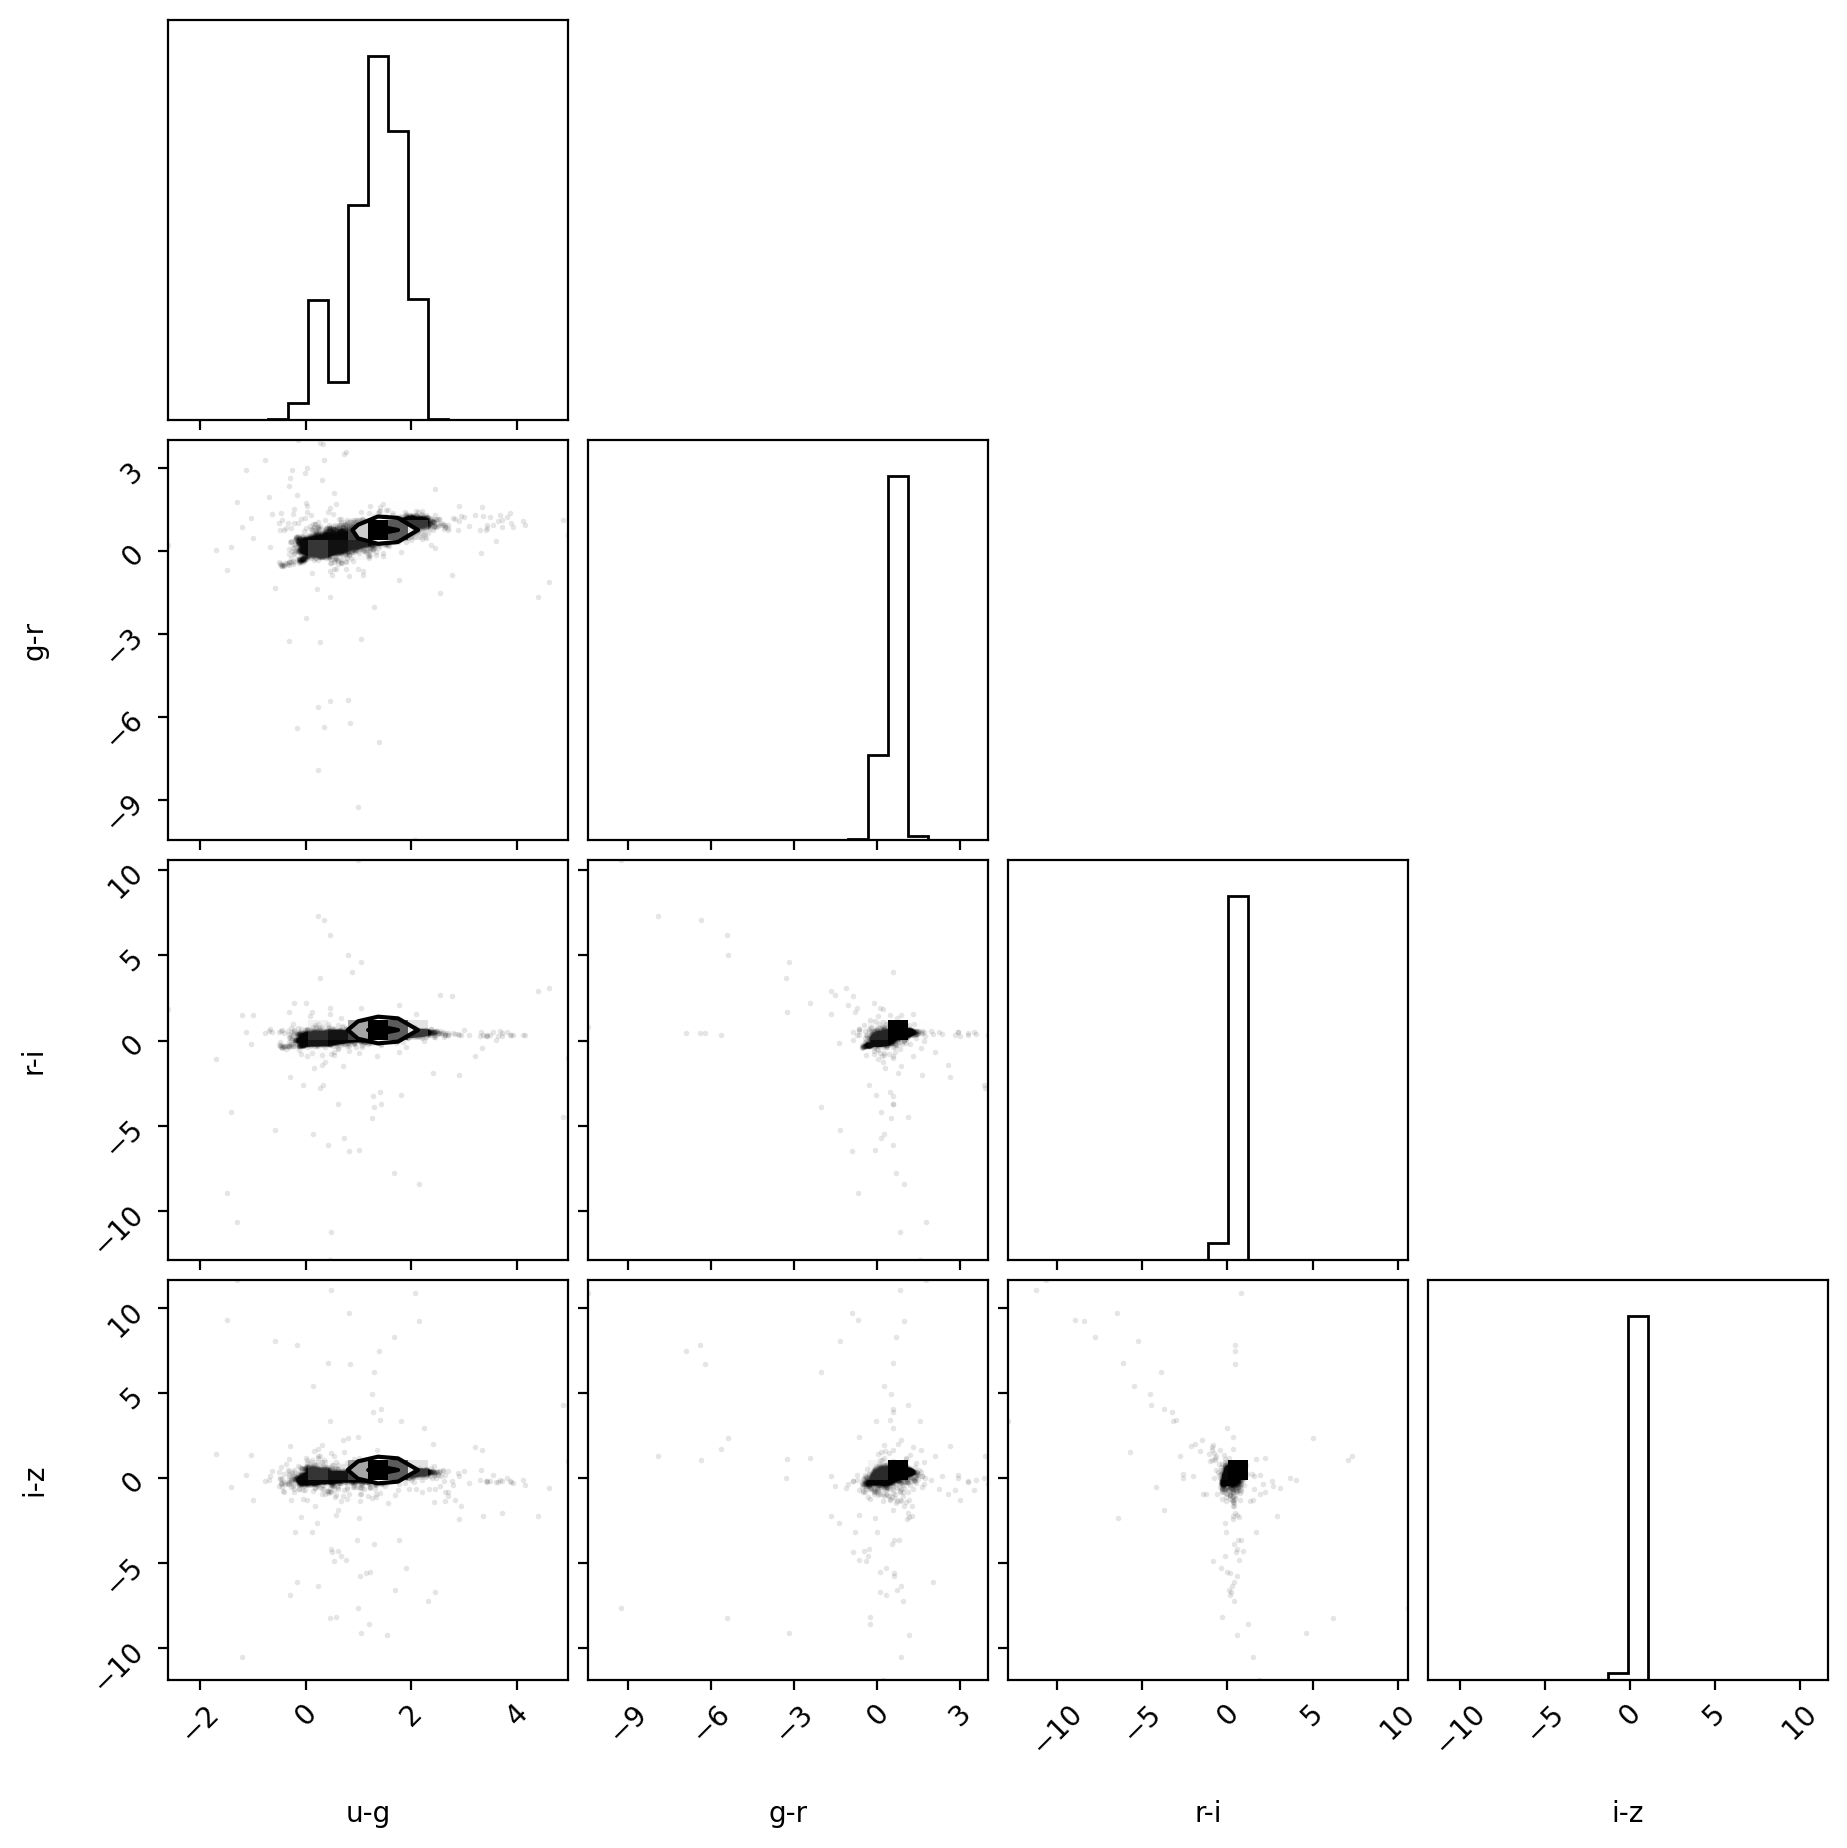

In [6]:
import corner
corner.corner(np.array([u_g, g_r, r_i, i_z]).T, labels=legends);

### Color Distribution

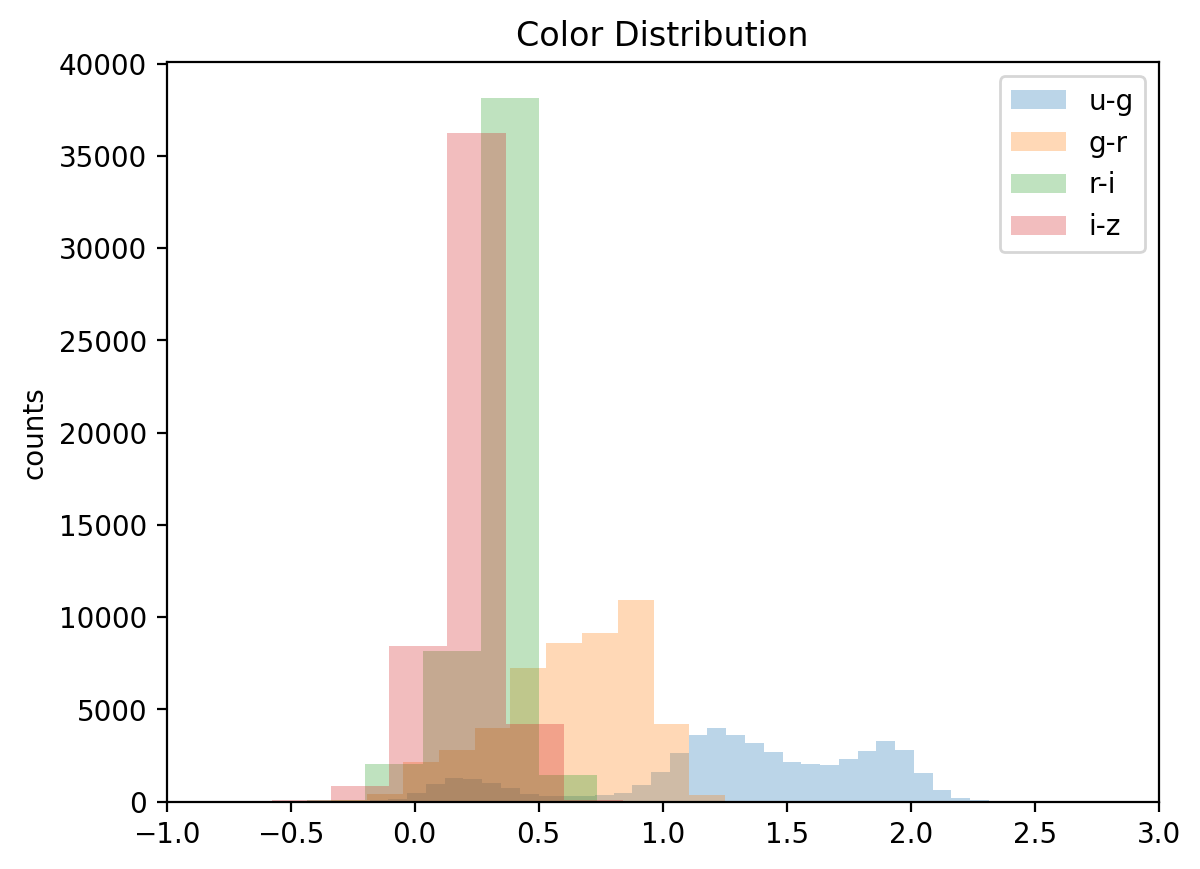

In [7]:
plt.hist(u_g, bins=100, alpha=0.3, label='u-g')
plt.hist(g_r, bins=100, alpha=0.3, label='g-r')
plt.hist(r_i, bins=100, alpha=0.3, label='r-i')
plt.hist(i_z, bins=100, alpha=0.3, label='i-z')
plt.ylabel('counts')
plt.xlim(-1.0, 3.0)
plt.title('Color Distribution')
plt.legend();

### Galaxies or Quasars?

In [8]:
galaxies_idx = np.array(np.where(data['class']=='GALAXY'))
quasars_idx  = np.array(np.where(data['class']=='QSO'))

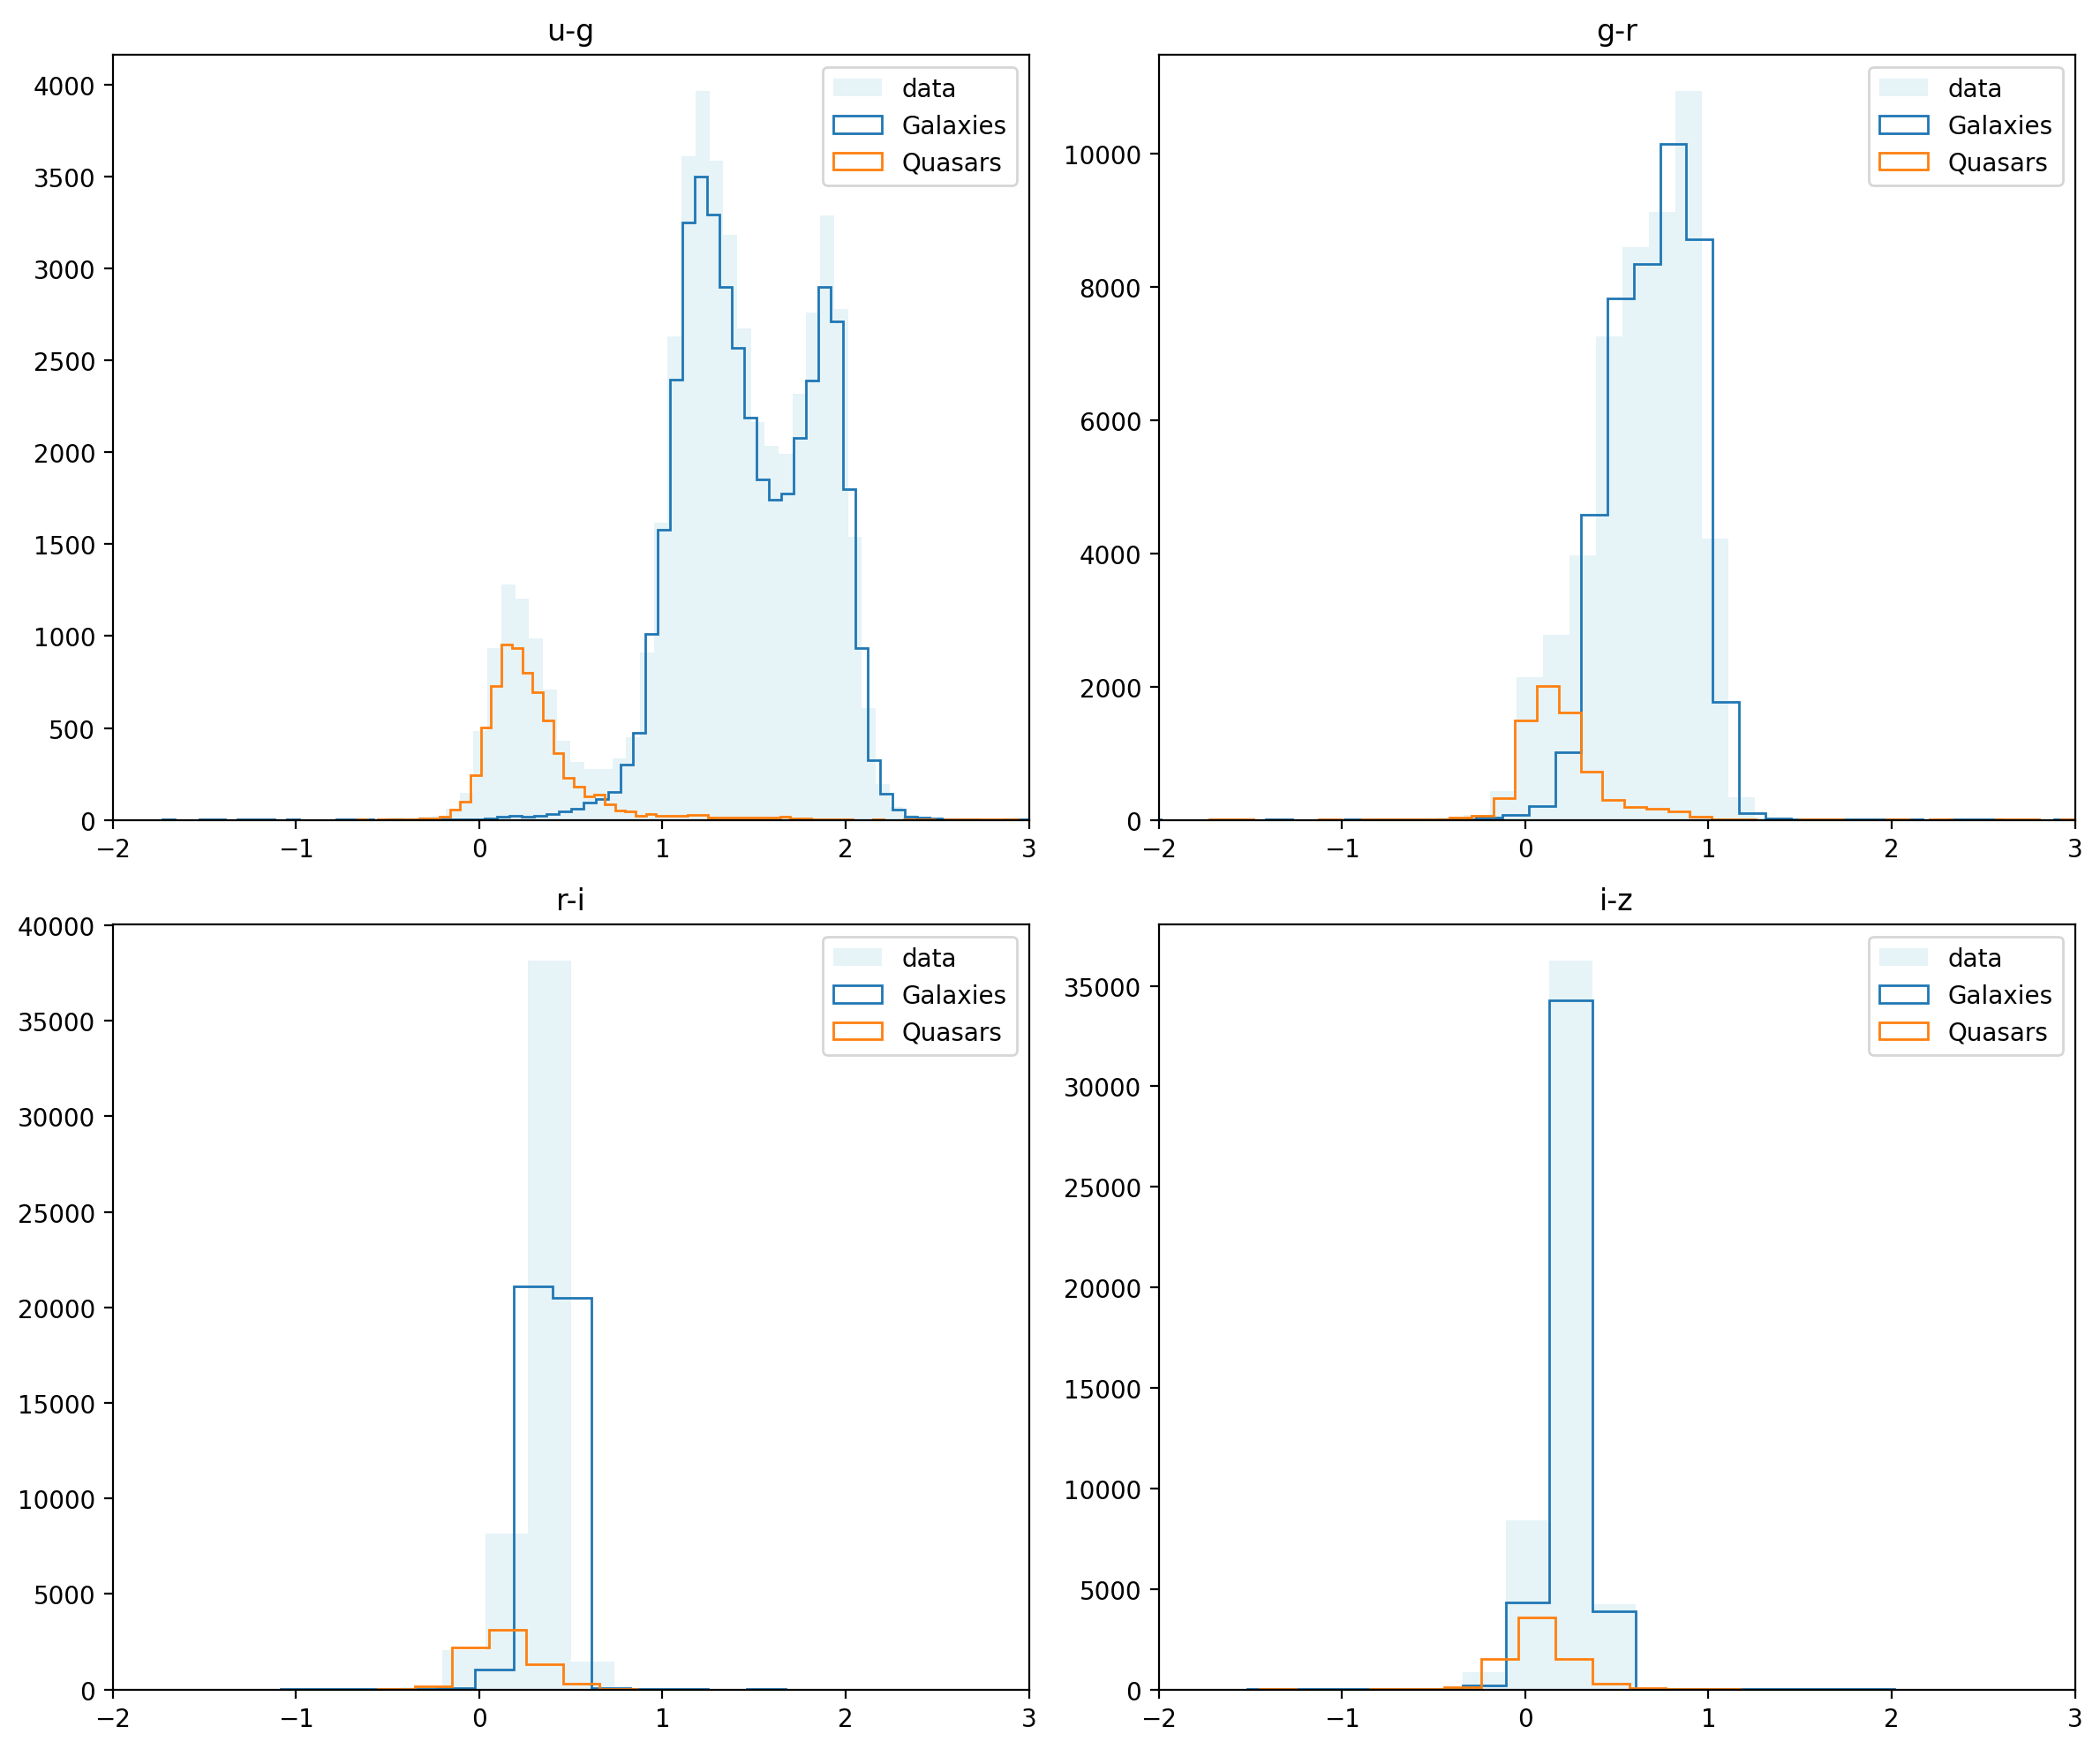

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))

for i, ax, xlabel in zip(np.arange(0,4), axes.flatten(), legends):
    dataset = ND_dataset[:,i]
    ax.hist(dataset, bins=100, label='data', color='lightblue', alpha=0.3)
    ax.hist(dataset[labels_01==0], bins=100, histtype='step', label='Galaxies')
    ax.hist(dataset[labels_01==1], bins=100, histtype='step', label='Quasars')
    ax.legend()
    ax.set_xlim(-2, 3)
    ax.set_title(xlabel)

plt.tight_layout();


We can clearly see a **bimodality** in the $u-g$ color!

## Classification

### Split the dataset into a train and a test set

In [10]:
# Subset (u-g)
X_train, X_test, y_train, y_test = train_test_split(u_g, labels_01, test_size=0.33, random_state=1)

# all data
X_train_all, X_test_all, y_train_all, y_test_all =  train_test_split(ND_dataset, labels_01, test_size=0.33, random_state=1)

### Naive Bayes
#### u-g

In [11]:
gnb = GaussianNB()
gnb.fit(X_train[:,None], y_train)

y_pred_GNB = gnb.predict(X_test[:,None])

In [12]:
completenessGNB, contaminationGNB = completeness_contamination(y_pred_GNB, y_test)

print(f'Completeness:   {completenessGNB:.3f}')
print(f'Contamination:  {contaminationGNB:.3f}')

Completeness:   0.937
Contamination:  0.067


##### Roc Curve

In [13]:
y_score_GNB = [gnb.predict_proba(X_test[:,None])[:,0], gnb.predict_proba(X_test[:,None])[:,1]]

Text(0.5, 1.0, 'ROC Curve')

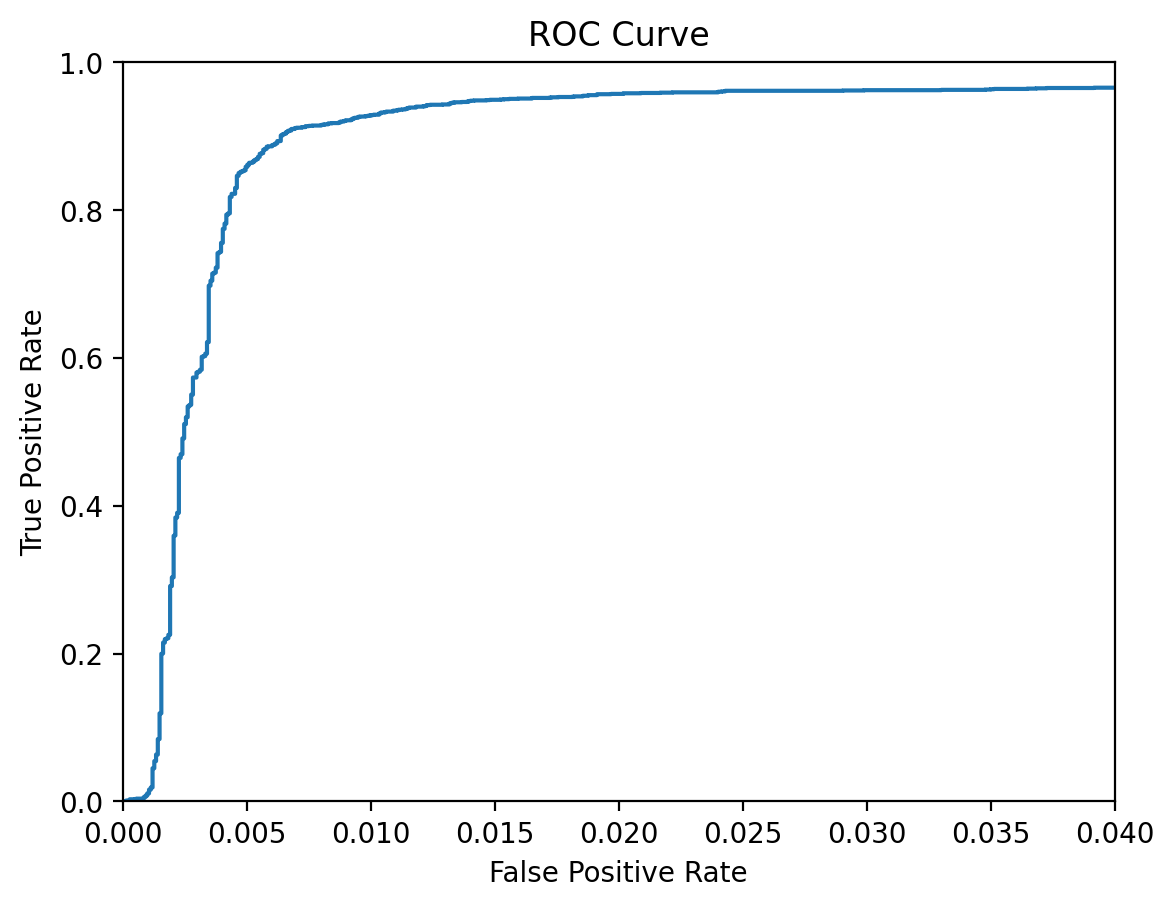

In [14]:
fpr, tpr, _ = roc_curve(y_test, y_score_GNB[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

#### Complete Dataset

In [15]:
gnb_all = GaussianNB()
gnb_all.fit(X_train_all, y_train_all)
y_pred_GNB_all = gnb_all.predict(X_test_all)

In [16]:
completenessGNB_all, contaminationGNB_all = completeness_contamination(y_pred_GNB_all, y_test_all)

print(f'Completeness:   {completenessGNB_all:.3f}')
print(f'Contamination:  {contaminationGNB_all:.3f}')

Completeness:   0.930
Contamination:  0.109


##### Roc Curve

In [17]:
y_score_GNB_all = [gnb_all.predict_proba(X_test_all)[:,0], gnb_all.predict_proba(X_test_all)[:,1]]

Text(0.5, 1.0, 'ROC Curve')

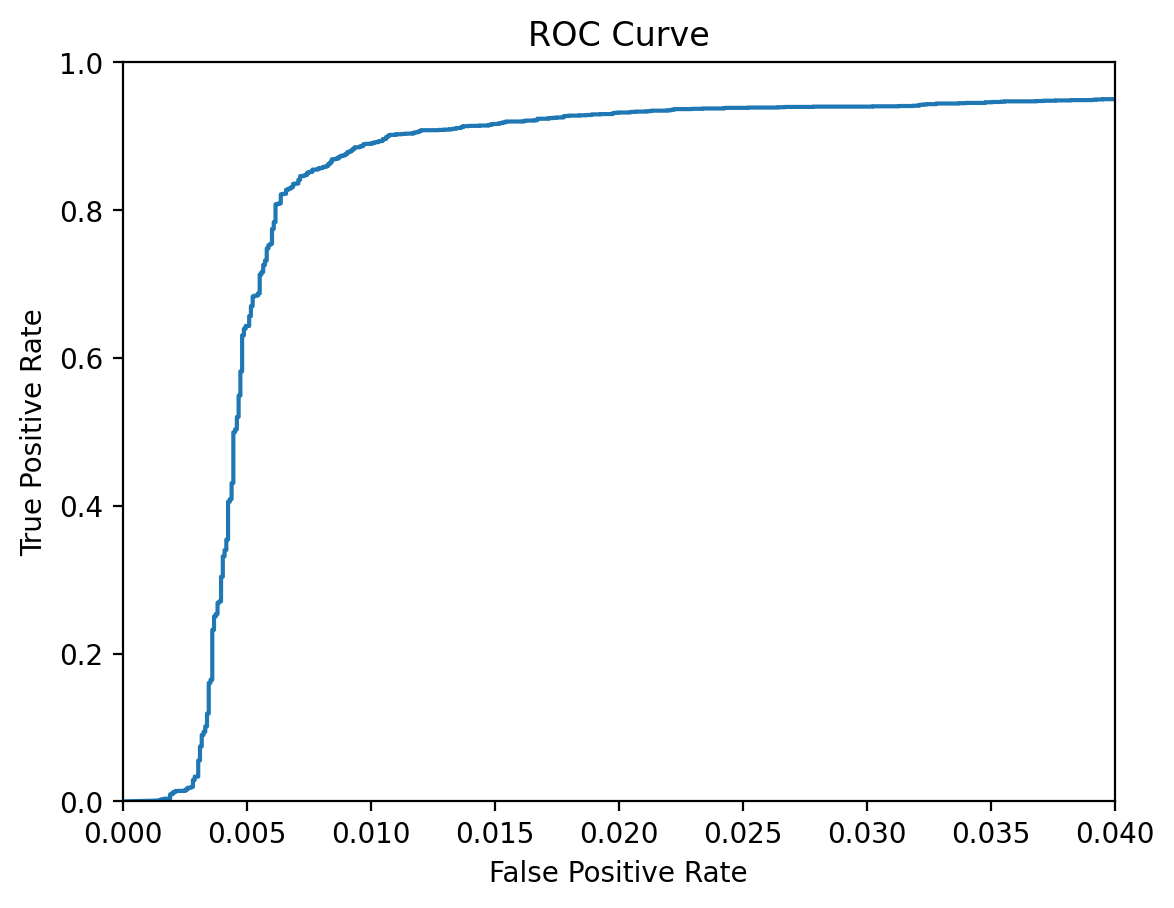

In [18]:
fpr, tpr, _ = roc_curve(y_test_all, y_score_GNB_all[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

### Linear Discriminant Analysis (LDA)

#### u-g

In [19]:
lda = LDA()
lda.fit(X_train[:,None], y_train)
y_pred_LDA = lda.predict(X_test[:,None])

In [20]:
completenessLDA, contaminationLDA = completeness_contamination(y_pred_LDA, y_test)

print(f'Completeness:   {completenessLDA:.3f}')
print(f'Contamination:  {contaminationLDA:.3f}')

Completeness:   0.938
Contamination:  0.068


##### Roc Curve

In [21]:
y_score_LDA = [lda.predict_proba(X_test[:,None])[:,0], lda.predict_proba(X_test[:,None])[:,1]]

Text(0.5, 1.0, 'ROC Curve')

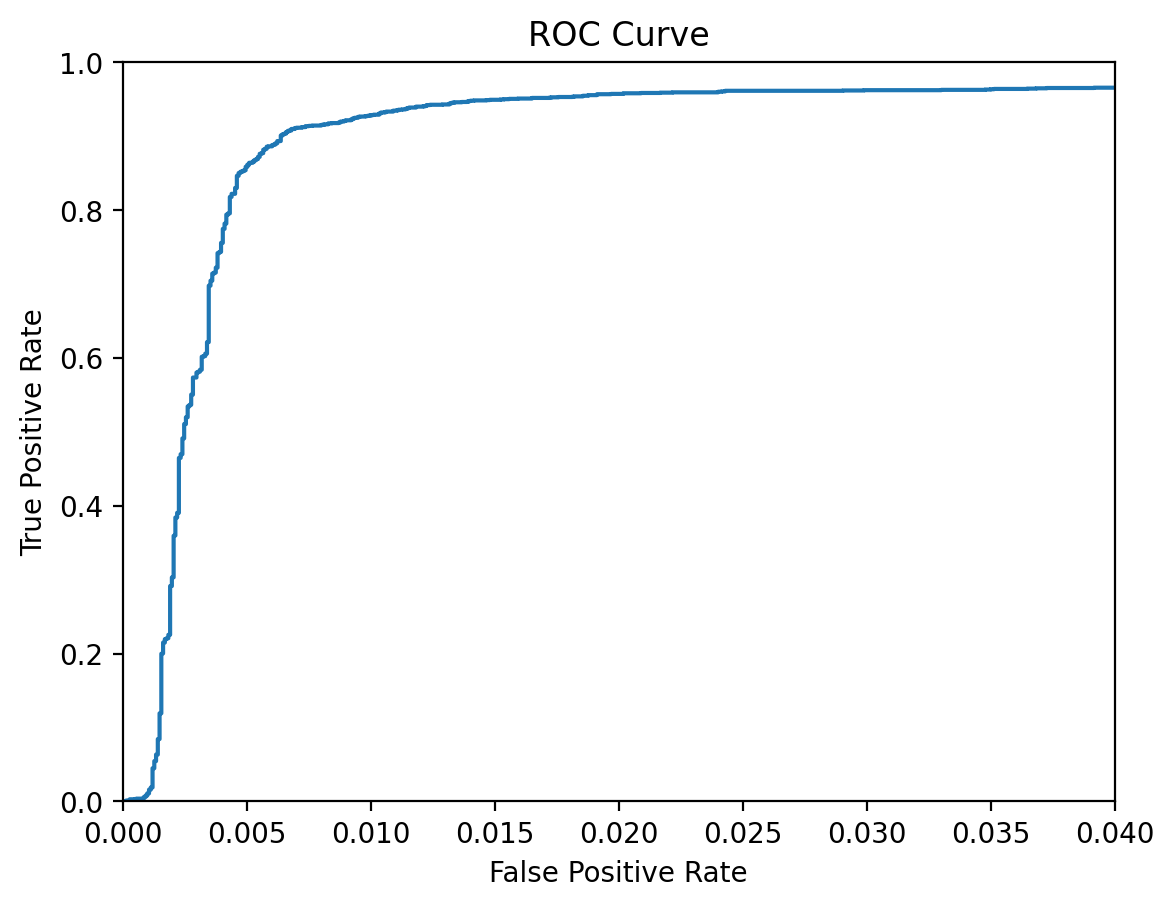

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_score_LDA[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

#### Complete Dataset

In [23]:
lda_all = LDA()
lda_all.fit(X_train_all, y_train_all)
y_pred_LDA_all = lda_all.predict(X_test_all)

In [24]:
completenessLDA_all, contaminationLDA_all = completeness_contamination(y_pred_LDA_all, y_test_all)

print(f'Completeness:   {completenessLDA_all:.3f}')
print(f'Contamination:  {contaminationLDA_all:.3f}')

Completeness:   0.936
Contamination:  0.061


##### Roc Curve

In [25]:
y_score_LDA_all = [lda_all.predict_proba(X_test_all)[:,0], lda_all.predict_proba(X_test_all)[:,1]]

Text(0.5, 1.0, 'ROC Curve')

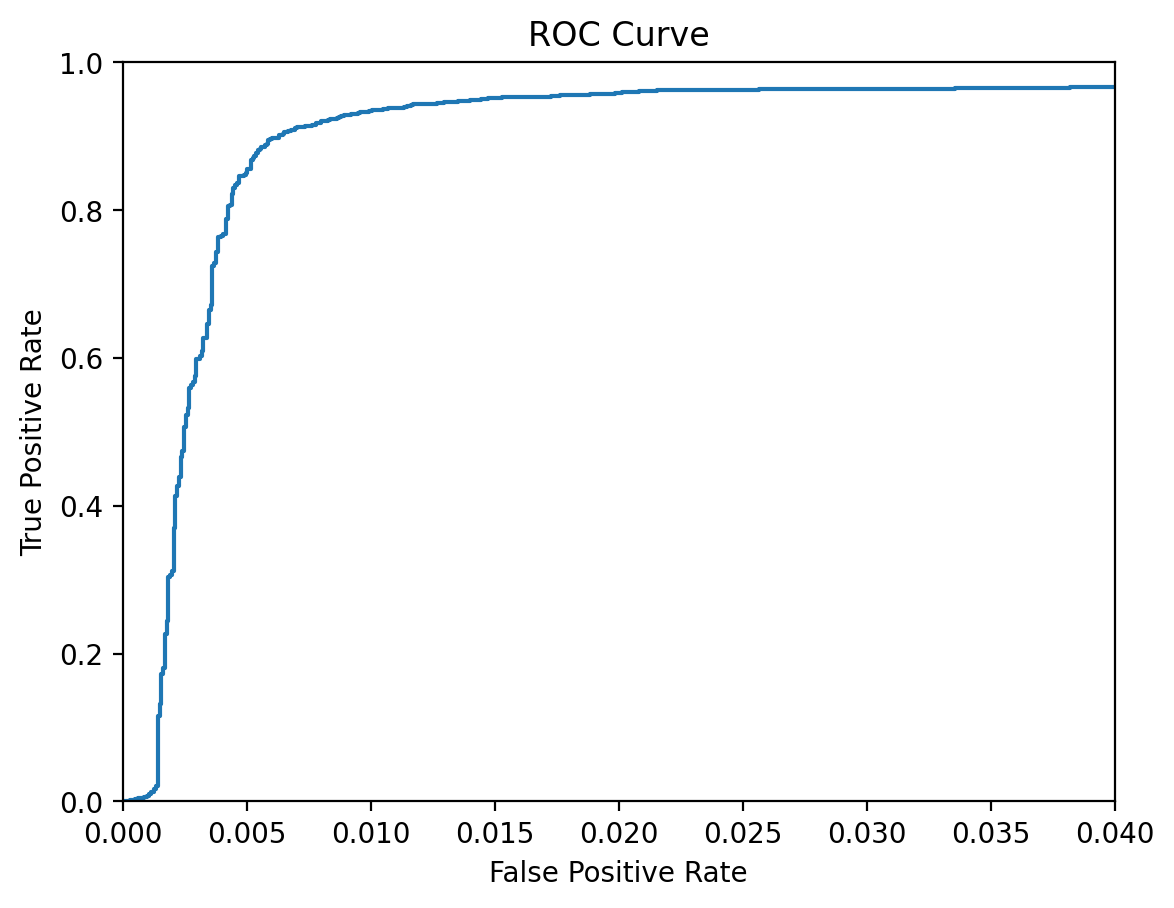

In [26]:
fpr, tpr, _ = roc_curve(y_test_all, y_score_LDA_all[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

### Quadratic Discriminant Analysis (QDA)

#### u-g

In [27]:
qda = QDA()
qda.fit(X_train[:,None], y_train)
y_pred_QDA = qda.predict(X_test[:,None])

In [28]:
completenessQDA, contaminationQDA = completeness_contamination(y_pred_QDA, y_test)

print(f'Completeness:   {completenessQDA:.3f}')
print(f'Contamination:  {contaminationQDA:.3f}')

Completeness:   0.937
Contamination:  0.067


##### Roc Curve

In [29]:
y_score_QDA = [qda.predict_proba(X_test[:,None])[:,0], qda.predict_proba(X_test[:,None])[:,1]]

Text(0.5, 1.0, 'ROC Curve')

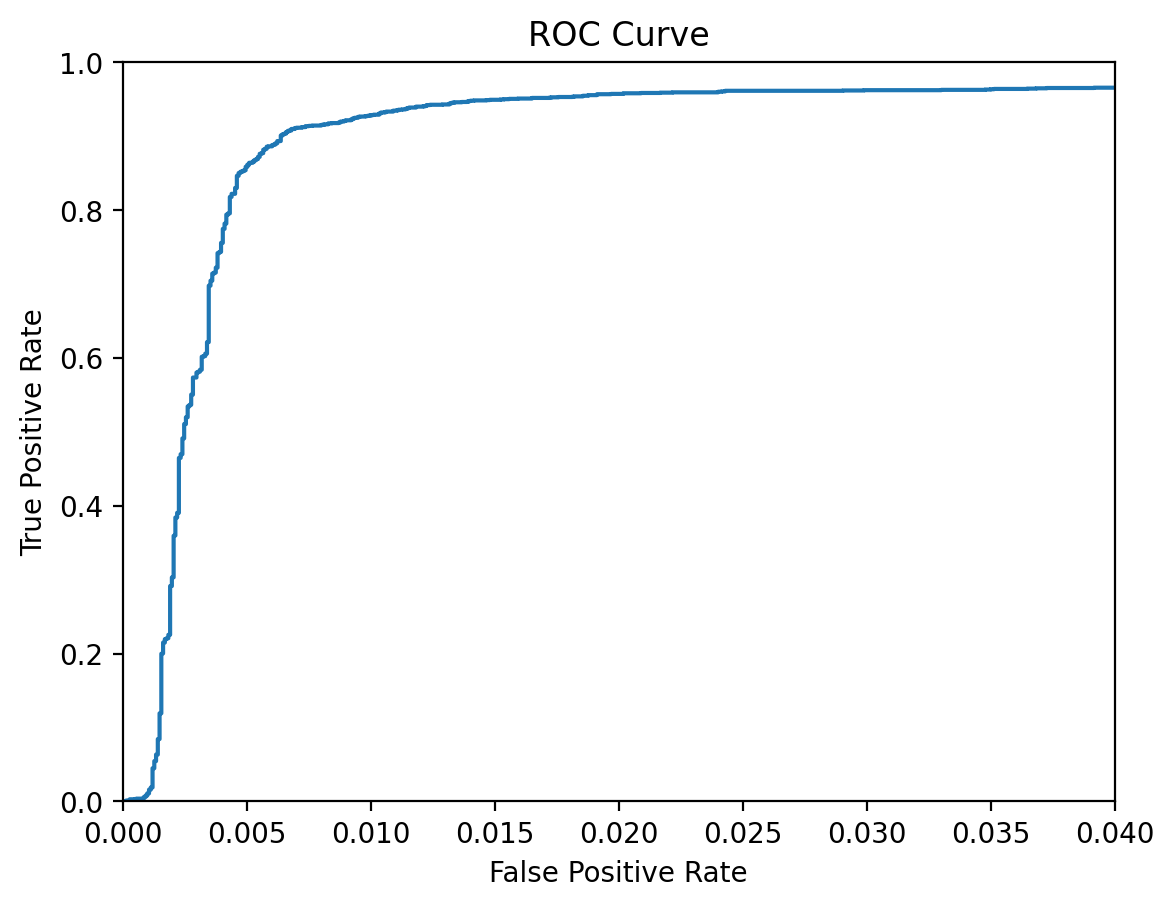

In [30]:
fpr, tpr, _ = roc_curve(y_test, y_score_QDA[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

#### Complete Dataset

In [31]:
qda_all = QDA()
qda_all.fit(X_train_all, y_train_all)
y_pred_QDA_all = qda_all.predict(X_test_all)

In [32]:
completenessQDA_all, contaminationQDA_all = completeness_contamination(y_pred_QDA_all, y_test_all)

print(f'Completeness:   {completenessQDA_all:.3f}')
print(f'Contamination:  {contaminationQDA_all:.3f}')

Completeness:   0.923
Contamination:  0.065


##### Roc Curve

In [33]:
y_score_QDA_all = [qda_all.predict_proba(X_test_all)[:,0], qda_all.predict_proba(X_test_all)[:,1]]

Text(0.5, 1.0, 'ROC Curve')

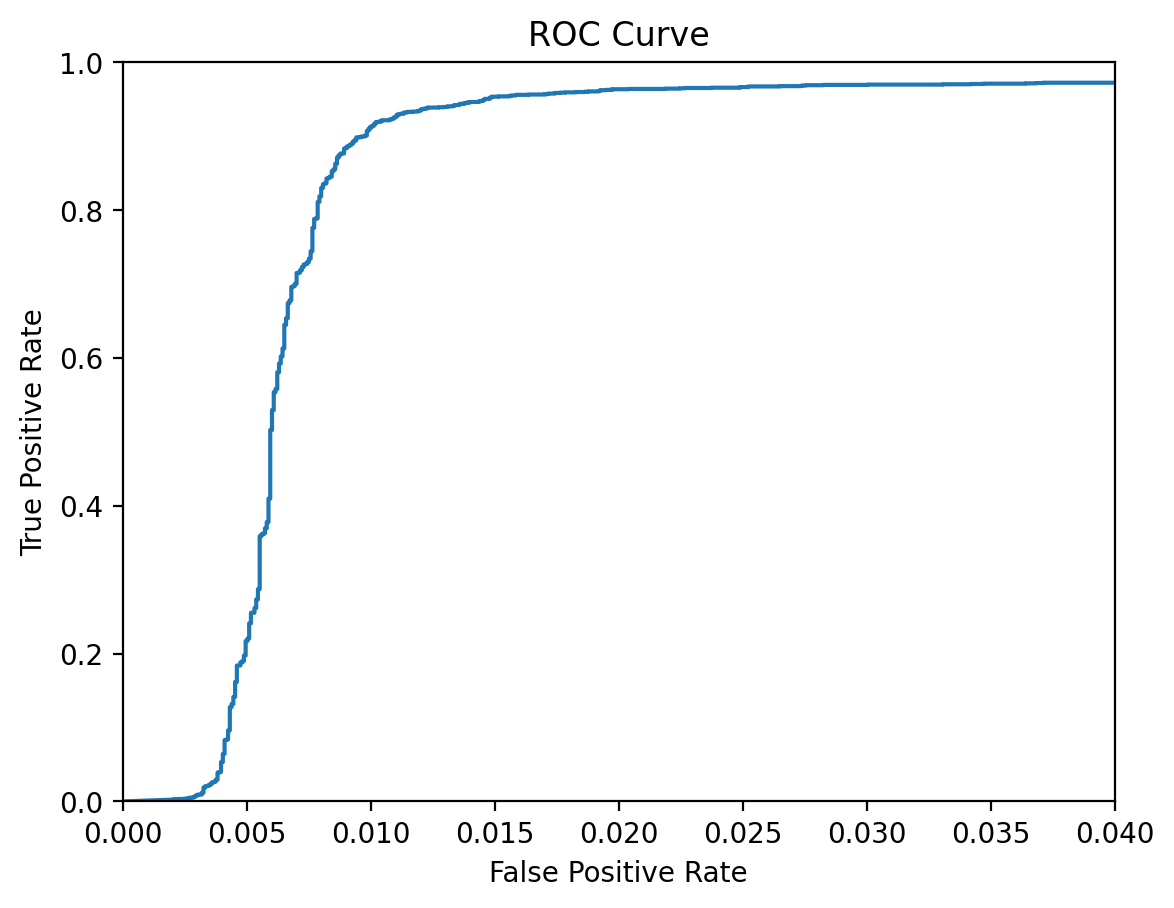

In [34]:
fpr, tpr, _ = roc_curve(y_test_all, y_score_QDA_all[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

### Gaussian Mixture Models (GMM)

#### u-g

In [35]:
# How many gaussians? --> CV
classification_acc = []
ks = np.arange(2,30)

for k in ks:
    gmm = GMMBayes(k)
    CV_pred_k = cross_val_predict(gmm, X_test[:,None], y_test)
    classification_acc.append(accuracy_score(y_test, CV_pred_k))

In [36]:
print(f'Max Accuracy for k = {ks[np.argmax(classification_acc)]}')

Max Accuracy for k = 7


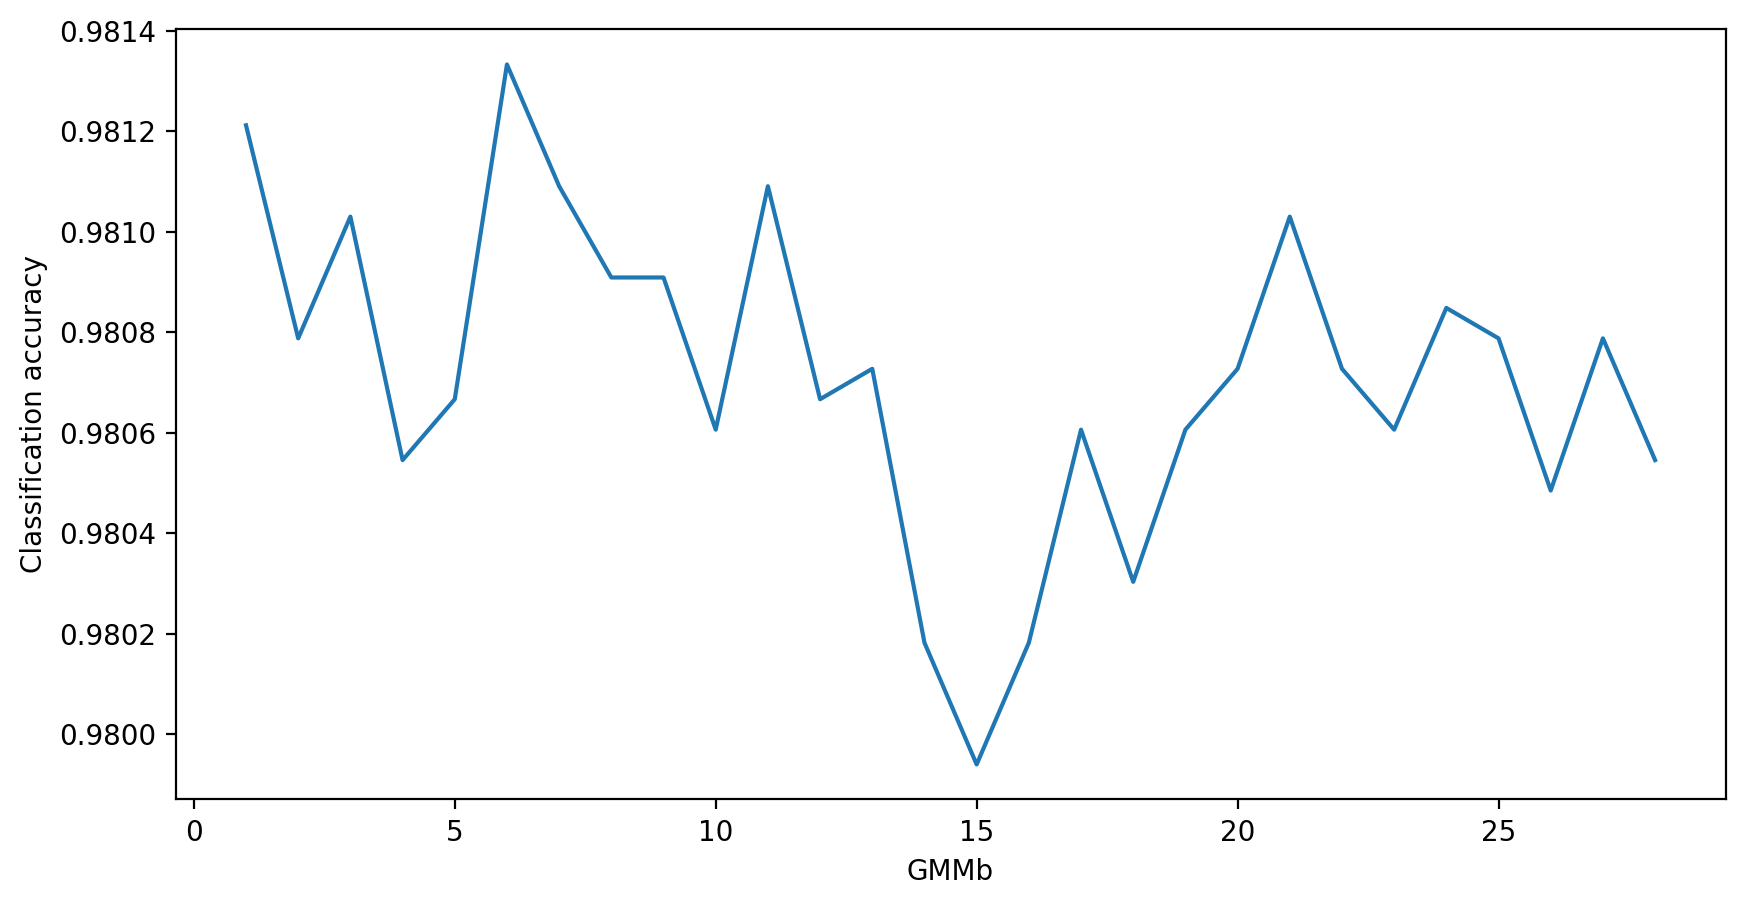

In [37]:
fig = plt.figure(figsize=(10, 5))
u = np.arange(len(classification_acc))+1
plt.plot(u,classification_acc)
plt.xlabel('GMMb')
plt.ylabel('Classification accuracy');

In [38]:
gmmb = GMMBayes(ks[np.argmax(accuracy_score)]) 
gmmb.fit(X_train[:, None], y_train)

y_pred_GMM = gmmb.predict(X_test[:, None])

In [39]:
completenessGMM, contaminationGMM = completeness_contamination(y_pred_GMM, y_test)

print(f'Completeness:  {completenessGMM:.3f}')
print(f'Contamination: {contaminationGMM:.3f}')


Completeness:  0.920
Contamination: 0.053


##### Roc Curve

In [40]:
y_score_GMM = [gmmb.predict_proba(X_test[:,None])[:,0], gmmb.predict_proba(X_test[:,None])[:,1]]

Text(0.5, 1.0, 'ROC Curve')

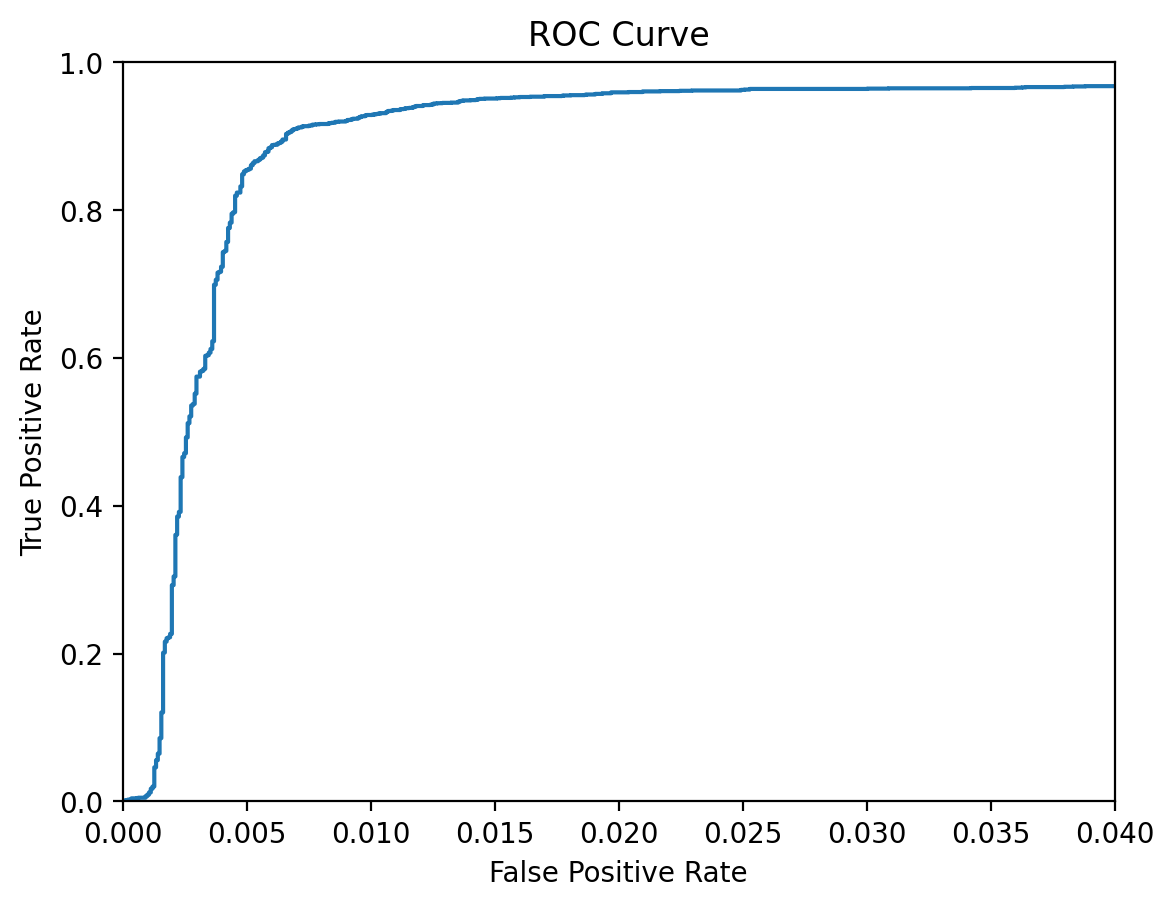

In [41]:
fpr, tpr, _ = roc_curve(y_test, y_score_GMM[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

#### Full Dataset

In [42]:
# How many gaussians? --> CV
classification_acc_all = []
ks = np.arange(2,30)

for k in ks:
    gmm = GMMBayes(k)
    CV_pred_k = cross_val_predict(gmm, X_test_all, y_test_all)
    classification_acc_all.append(accuracy_score(y_test_all, CV_pred_k))

In [43]:
print(f'Max Accuracy for k = {ks[np.argmax(classification_acc_all)]}')

Max Accuracy for k = 16


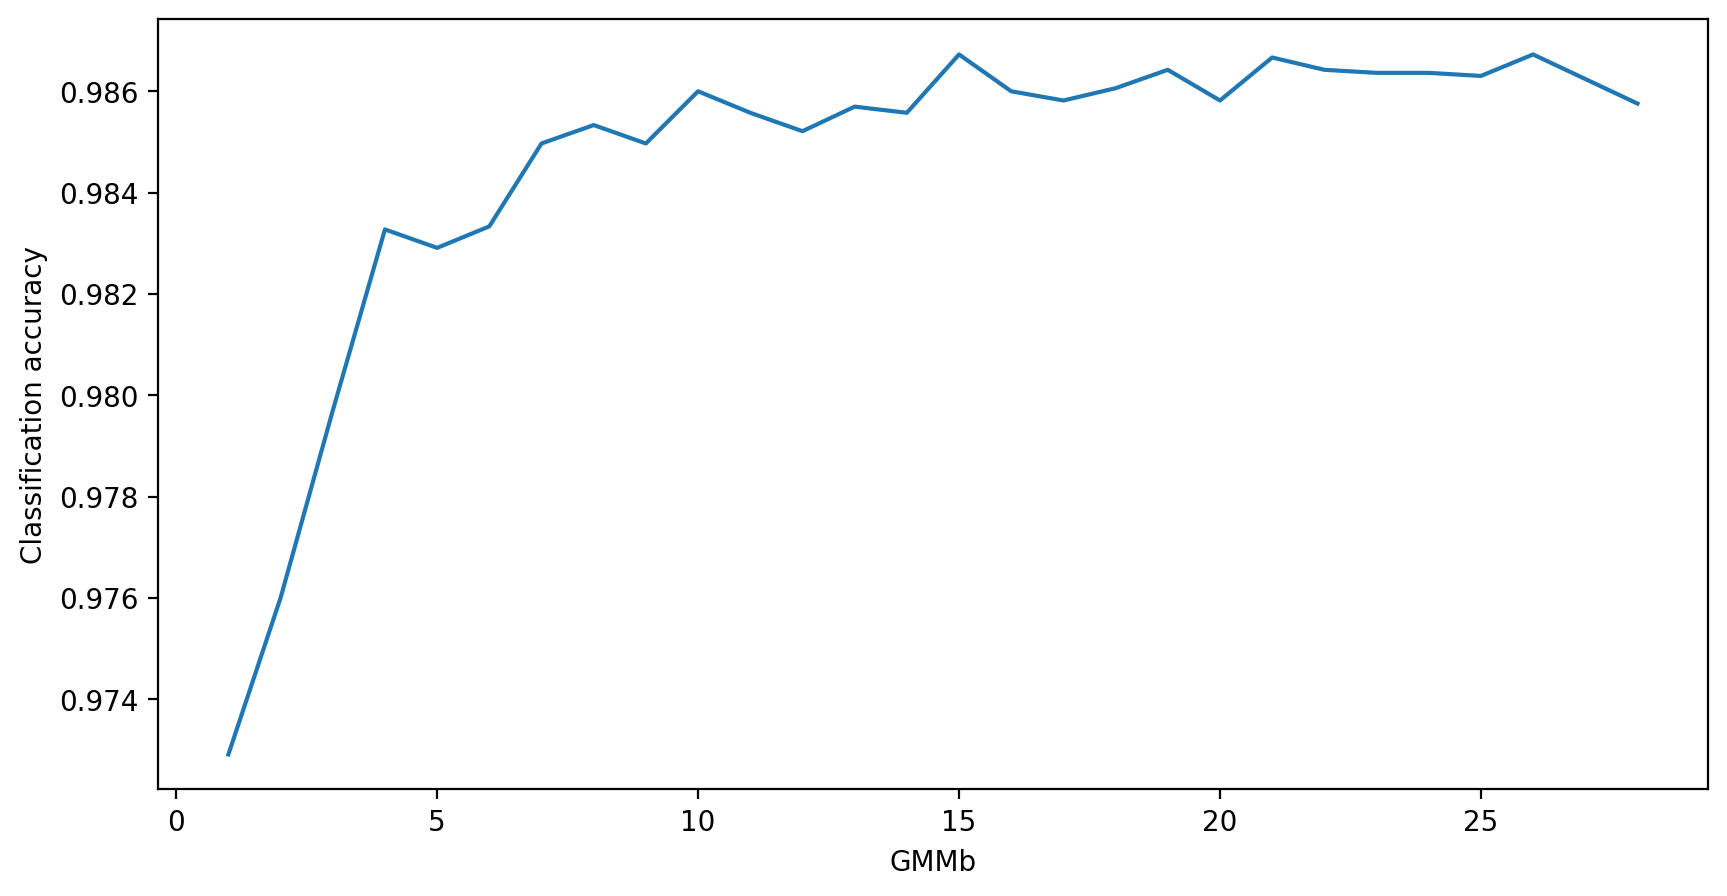

In [44]:
fig = plt.figure(figsize=(10, 5))
u = np.arange(len(classification_acc_all))+1
plt.plot(u,classification_acc_all)
plt.xlabel('GMMb')
plt.ylabel('Classification accuracy');

In [45]:
gmmb_all = GMMBayes(ks[np.argmax(classification_acc_all)])
gmmb_all.fit(X_train_all, y_train_all)
y_pred_GMM_all = gmmb_all.predict(X_test_all)

In [46]:
completenessGMM_all, contaminationGMM_all = completeness_contamination(y_pred_GMM_all, y_test_all)

print(f'Completeness:  {completenessGMM_all:.3f}')
print(f'Contamination: {contaminationGMM_all:.3f}')

Completeness:  0.953
Contamination: 0.047


##### Roc Curve

In [47]:
y_score_GMM_all = [gmmb_all.predict_proba(X_test_all)[:,0], gmmb_all.predict_proba(X_test_all)[:,1]]

Text(0.5, 1.0, 'ROC Curve')

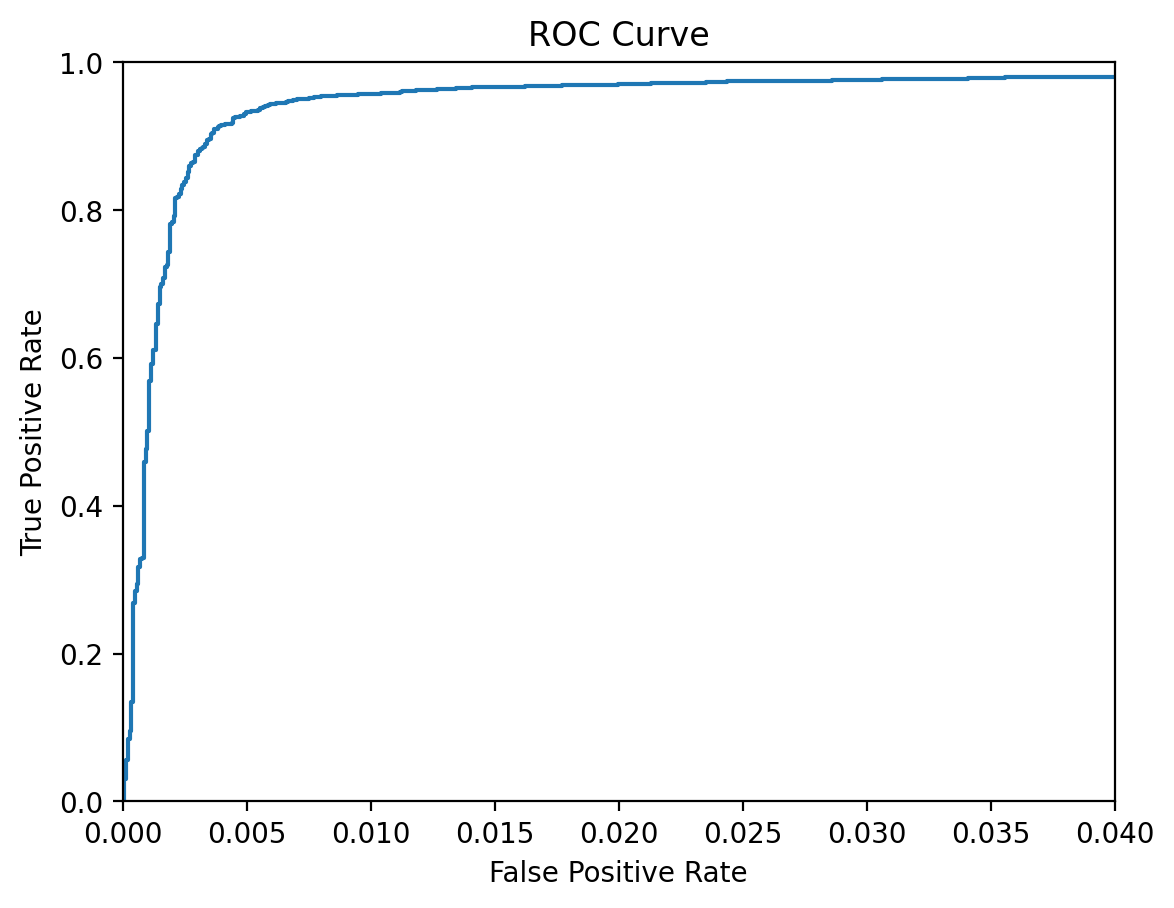

In [48]:
fpr, tpr, _ = roc_curve(y_test_all, y_score_GMM_all[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

### K-Nearest Neighbors (KNN)

In [49]:
import warnings
warnings.filterwarnings('ignore')   # Avoid Warnings

#### u-g

In [50]:
# How many neighbors? --> CV
classification_acc = []
ks = np.arange(1,30)

for k in ks:
    knn = KNeighborsClassifier(k)
    CV_pred_k = cross_val_predict(knn, X_test[:,None], y_test)
    classification_acc.append(accuracy_score(y_test, CV_pred_k))

In [51]:
print(f'Max Accuracy for k = {ks[np.argmax(classification_acc)]}')

Max Accuracy for k = 29


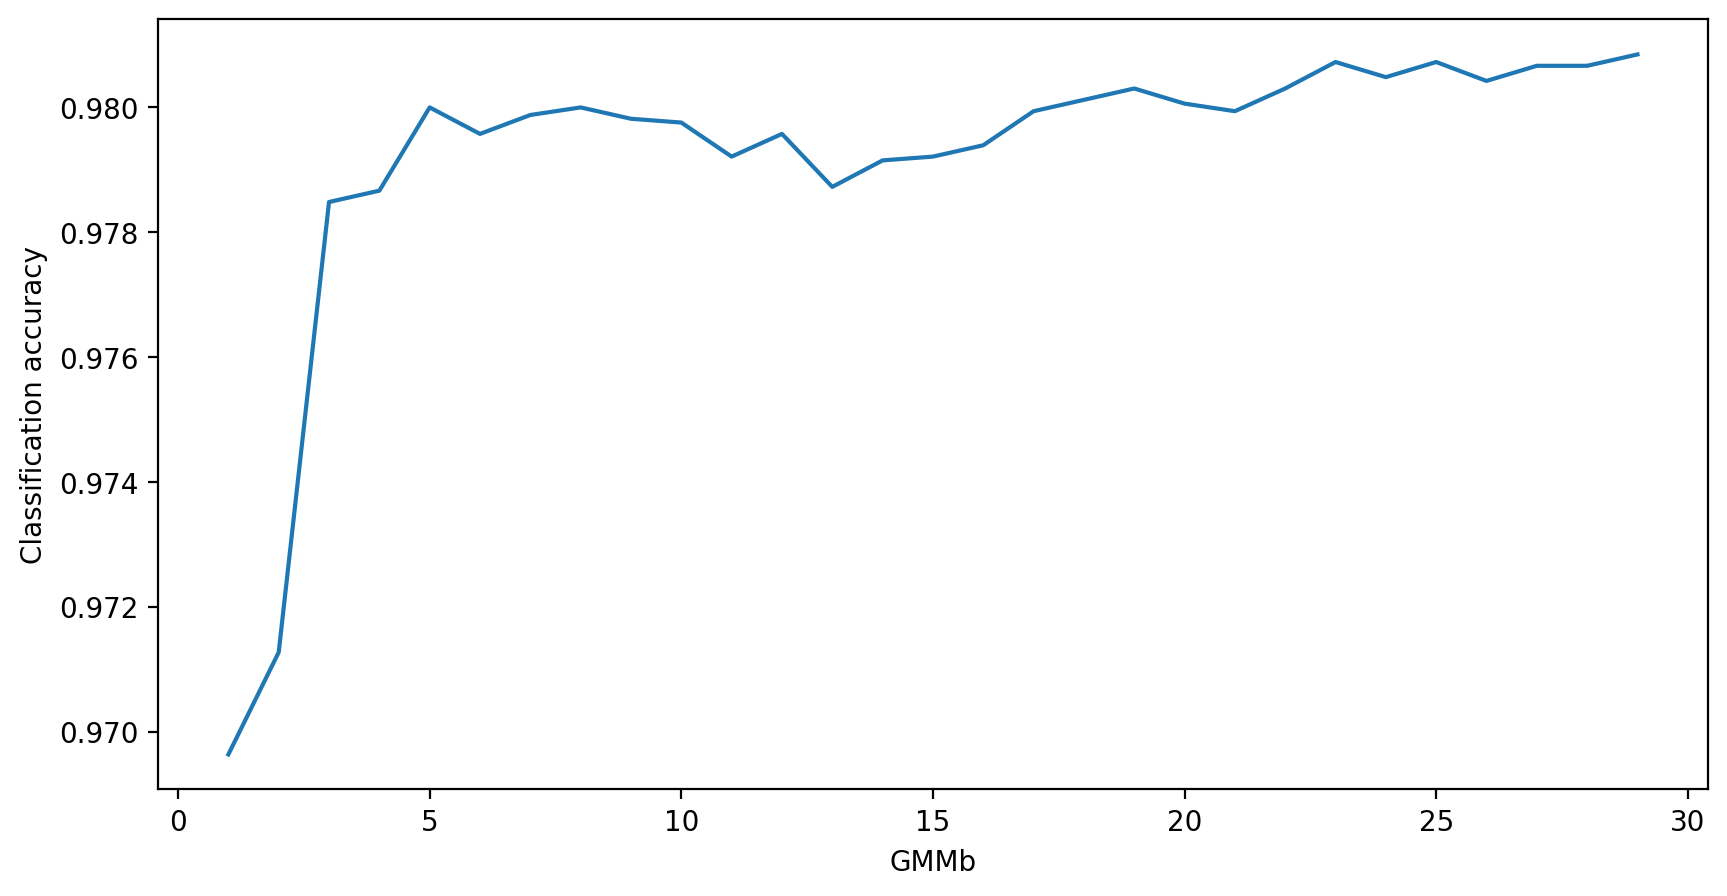

In [52]:
fig = plt.figure(figsize=(10, 5))
u = np.arange(len(classification_acc))+1
plt.plot(u,classification_acc)
plt.xlabel('GMMb')
plt.ylabel('Classification accuracy');

In [53]:
knc = KNeighborsClassifier(ks[np.argmax(classification_acc)])
knc.fit(X_train[:,None], y_train)

y_pred_KNC = knc.predict(X_test[:,None])

completenessKNC, contaminationKNC = completeness_contamination(y_pred_KNC, y_test)

print(f'Completeness:  {completenessKNC:.3f}')
print(f'Contamination: {contaminationKNC:.3f}')

Completeness:  0.940
Contamination: 0.072


##### ROC Curve

In [54]:
y_score_KNC = [knc.predict_proba(X_test[:,None])[:,0], knc.predict_proba(X_test[:,None])[:,1]]

Text(0.5, 1.0, 'ROC Curve')

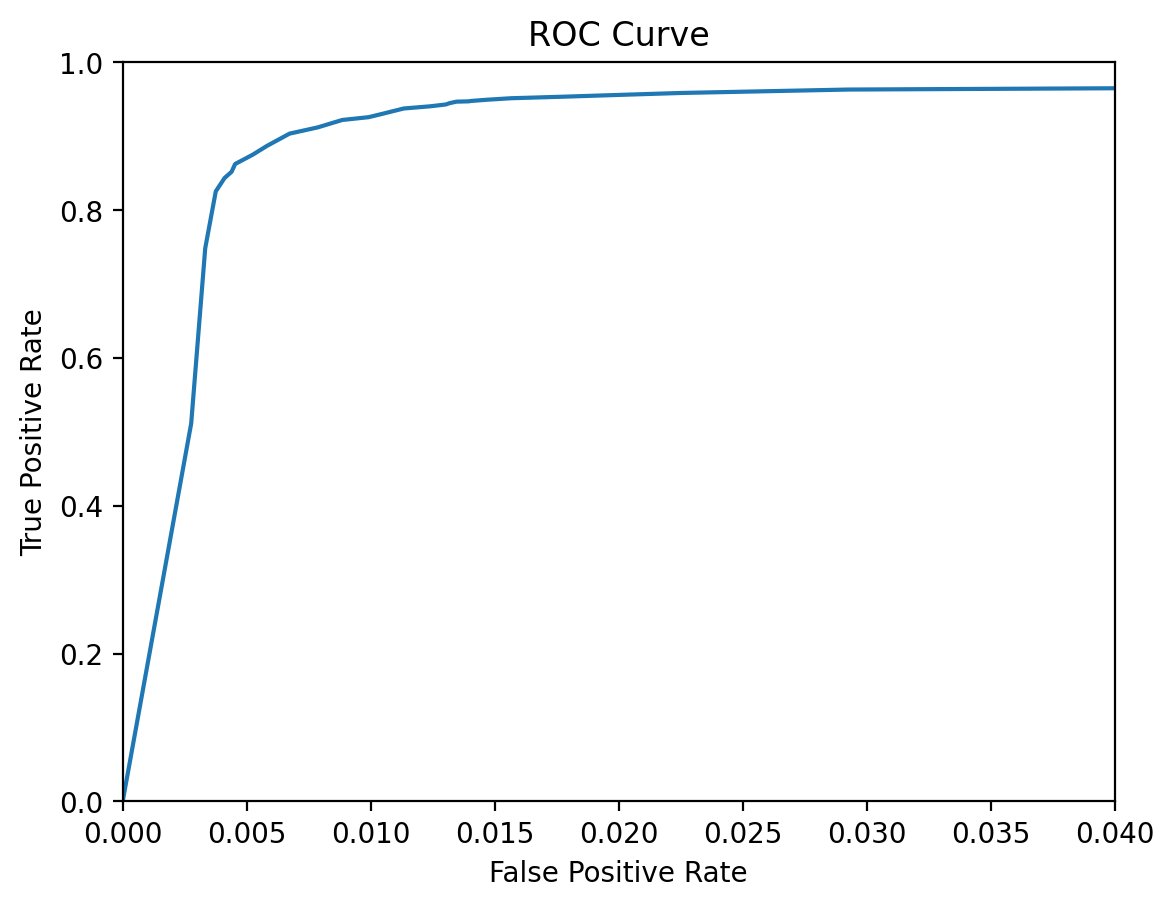

In [55]:
fpr, tpr, _ = roc_curve(y_test, y_score_KNC[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

#### Full Dataset

In [56]:
# How many neighbors? --> CV
classification_acc_all = []
ks = np.arange(1,30)

for k in ks:
    knn = KNeighborsClassifier(k)
    CV_pred_k = cross_val_predict(knn, X_test_all, y_test_all)
    classification_acc_all.append(accuracy_score(y_test_all, CV_pred_k))

In [57]:
print(f'Max Accuracy for k = {ks[np.argmax(classification_acc_all)]}')

Max Accuracy for k = 7


In [58]:
knc_all = KNeighborsClassifier(ks[np.argmax(classification_acc_all)])
knc_all.fit(X_train_all, y_train)

y_pred_KNC_all = knc_all.predict(X_test_all)

completenessKNC_all, contaminationKNC_all = completeness_contamination(y_pred_KNC_all, y_test_all)

print(f'Completeness:  {completenessKNC_all:.3f}')
print(f'Contamination: {contaminationKNC_all:.3f}')

Completeness:  0.950
Contamination: 0.044


##### ROC Curve

In [59]:
y_score_KNC_all = [knc_all.predict_proba(X_test_all)[:,0], knc_all.predict_proba(X_test_all)[:,1]]

Text(0.5, 1.0, 'ROC Curve')

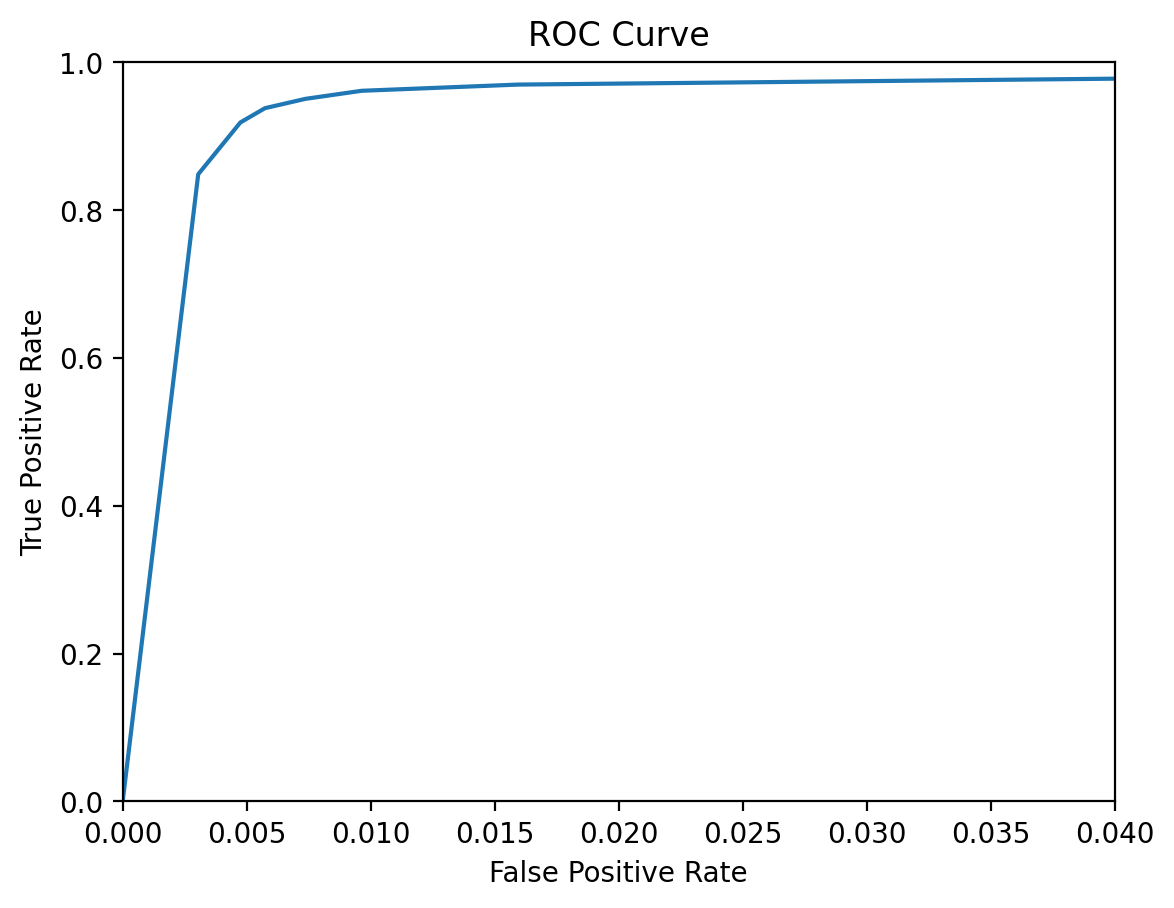

In [60]:
fpr, tpr, _ = roc_curve(y_test_all, y_score_KNC_all[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

## ROC Curves Comparison

In [61]:
# Fit all the models to the training data
def compute_models(*args):
    names = []
    probs = []
    
    print('classifiers: ')
    print(' ')
    
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train[:, None], y_train)
        
        #Note that we are outputing the probabilities [of class 1], not the classes
        y_probs = clf.predict_proba(X_test[:, None])[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs

In [62]:
names, probs = compute_models((GaussianNB, {}),
                              (LDA, {}),
                              (QDA, {}),
                              (KNeighborsClassifier,
                               dict(n_neighbors=29)),
                              (GMMBayes, dict(n_components=2)))

classifiers: 
 
GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
KNeighborsClassifier
GMMBayes


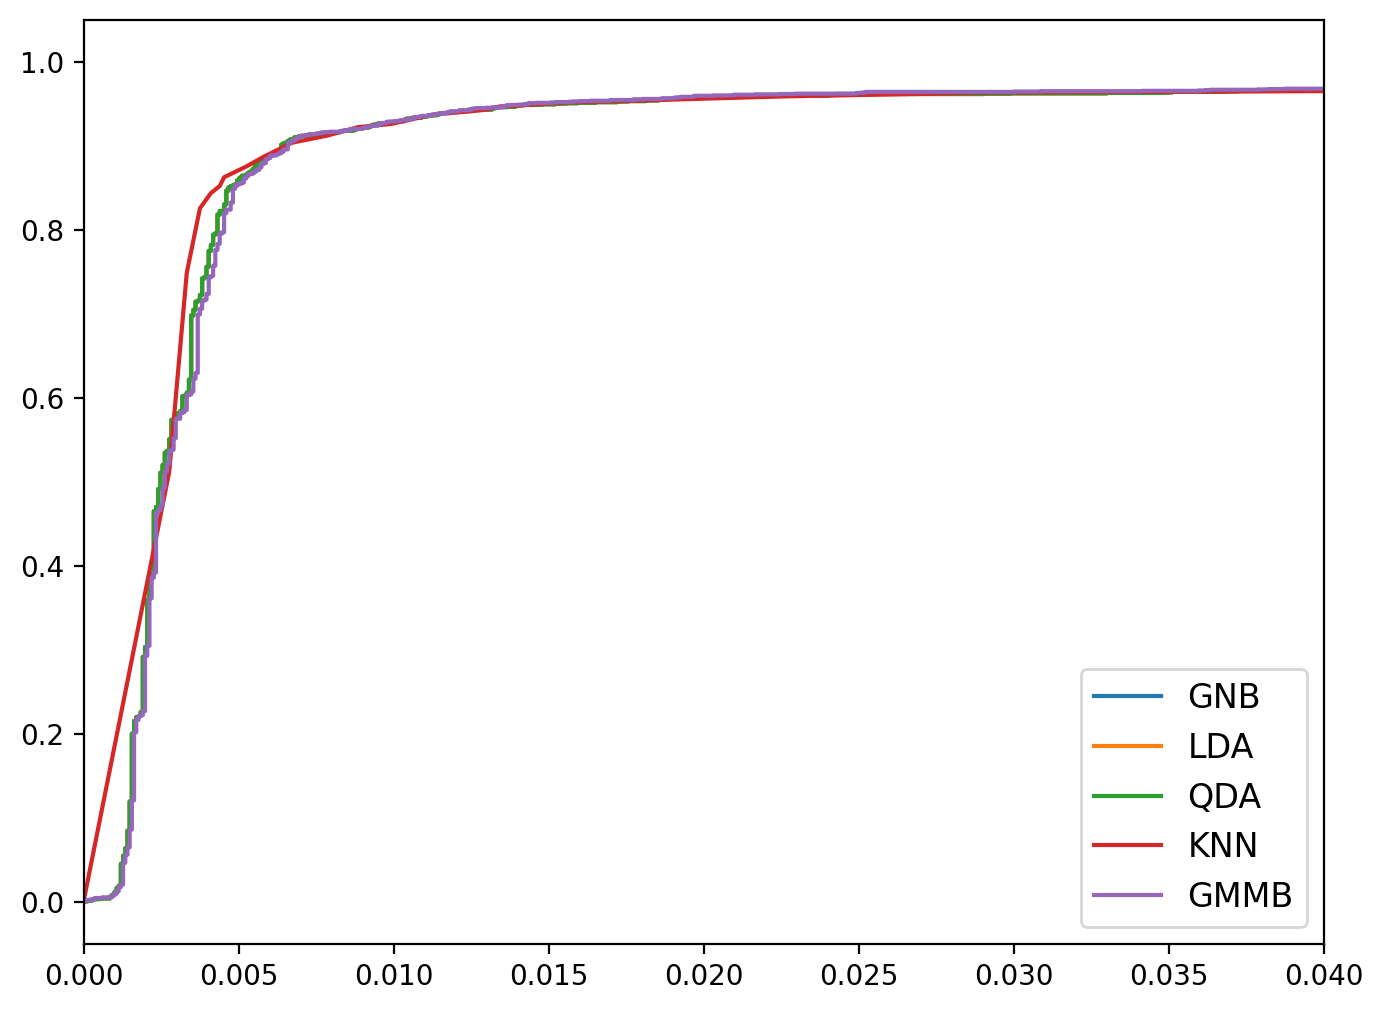

In [63]:
labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')

plt.figure(figsize=(8, 6))

for name, y_prob in zip(names, probs):
    
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])
    
    plt.plot(fpr, tpr, label=labels[name])
    
    plt.xlim(0, 0.04)
    
    plt.legend(loc='lower right', fontsize=12)

In [64]:
# Fit all the models to the training data
def compute_models_NDIM(*args):
    names = []
    probs = []
    
    print('classifiers: ')
    print(' ')
    
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train_all, y_train_all)
        
        #Note that we are outputing the probabilities [of class 1], not the classes!
        y_probs = clf.predict_proba(X_test_all)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs


In [65]:
names_NDIM, probs_NDIM = compute_models_NDIM((GaussianNB, {}),
                              (LDA, {}),
                              (QDA, {}),
                              (KNeighborsClassifier,
                               dict(n_neighbors=7)),
                              (GMMBayes, dict(n_components=22)))

classifiers: 
 
GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
KNeighborsClassifier
GMMBayes


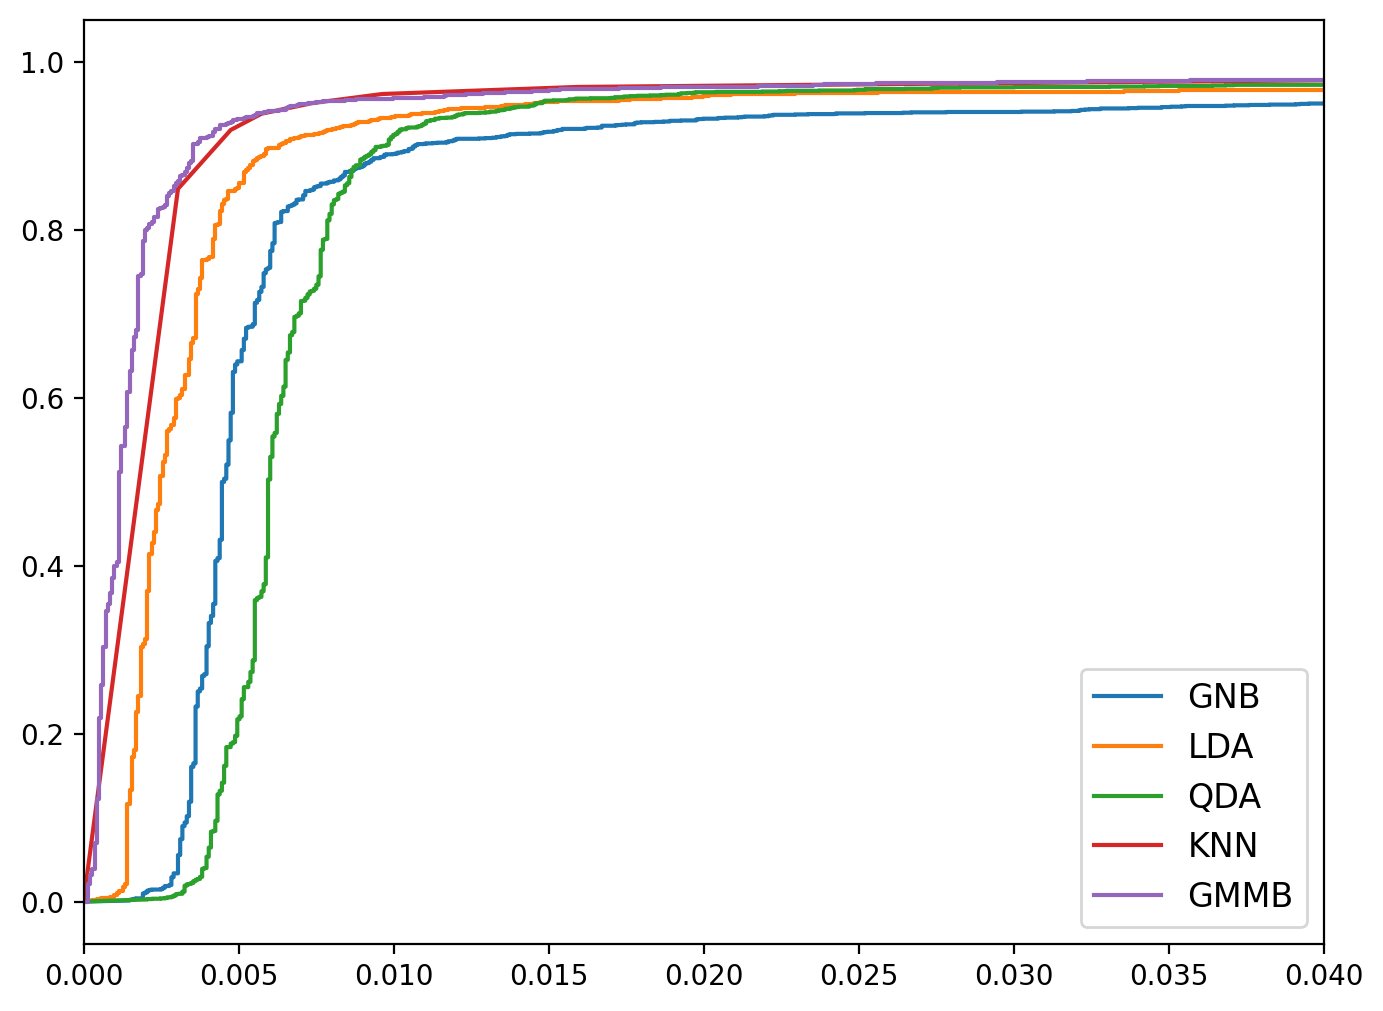

In [66]:
plt.figure(figsize=(8, 6))

for name, y_prob in zip(names_NDIM, probs_NDIM):
    
    fpr, tpr, thresh = roc_curve(y_test_all, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_test_all, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])
    
    plt.plot(fpr, tpr, label=labels[name])
    
    plt.xlim(0, 0.04)
    
    plt.legend(loc='lower right', fontsize=12)

## Different Colors (Using GMM)
Dataset used:
- u-g
- u-g, g-r
- u-g, g-r, r-i
- g-r, r-i, i-z
- all the datasets

In [67]:
# Define your classifiers
classifiers = [
    (GaussianNB, {}),
    (LDA, {}),
    (QDA, {}),
    (KNeighborsClassifier, dict(n_neighbors=7)),
    (GMMBayes, dict(n_components=22))
]

In [68]:
Dataset = np.hstack([u_g.reshape(-1, 1), g_r.reshape(-1, 1), r_i.reshape(-1, 1), i_z.reshape(-1, 1)])

subsets = {
    'u-g': u_g.reshape(-1,1),
    'u-g, g-r': np.vstack([u_g, g_r]).T,
    'u-g, g-r, r-i': np.vstack([u_g, g_r, r_i]).T,
    'g-r, r-i, i-z': np.vstack([g_r, r_i, i_z]).T,
    'u-g, g-r, r-i, i-z': Dataset    
}

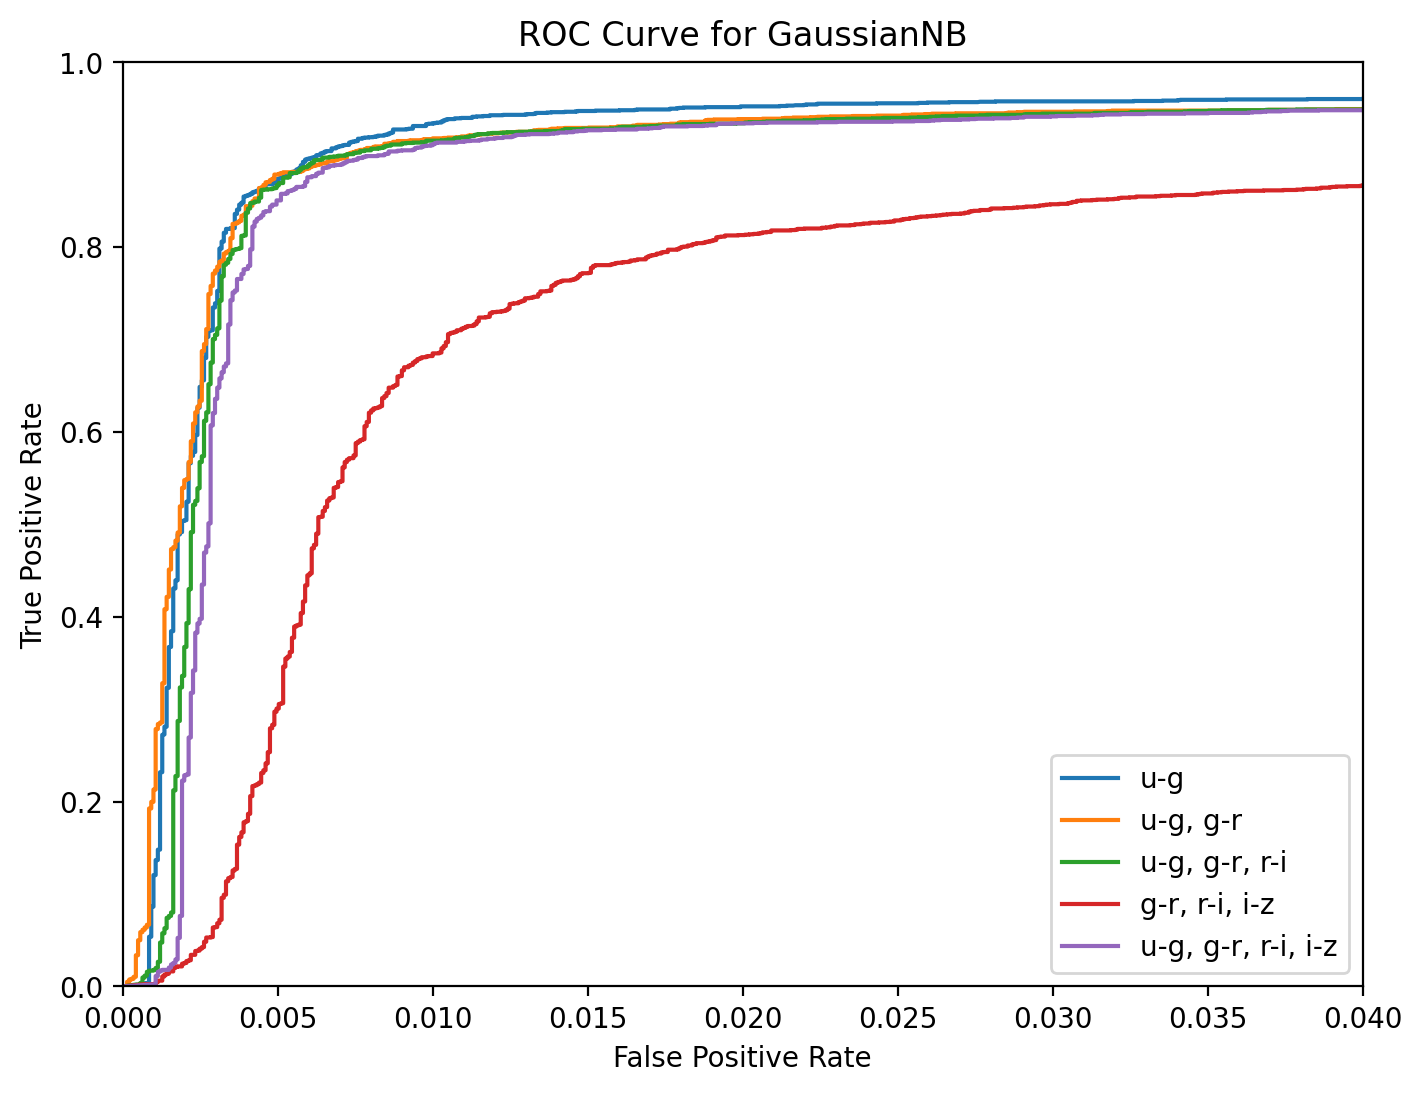

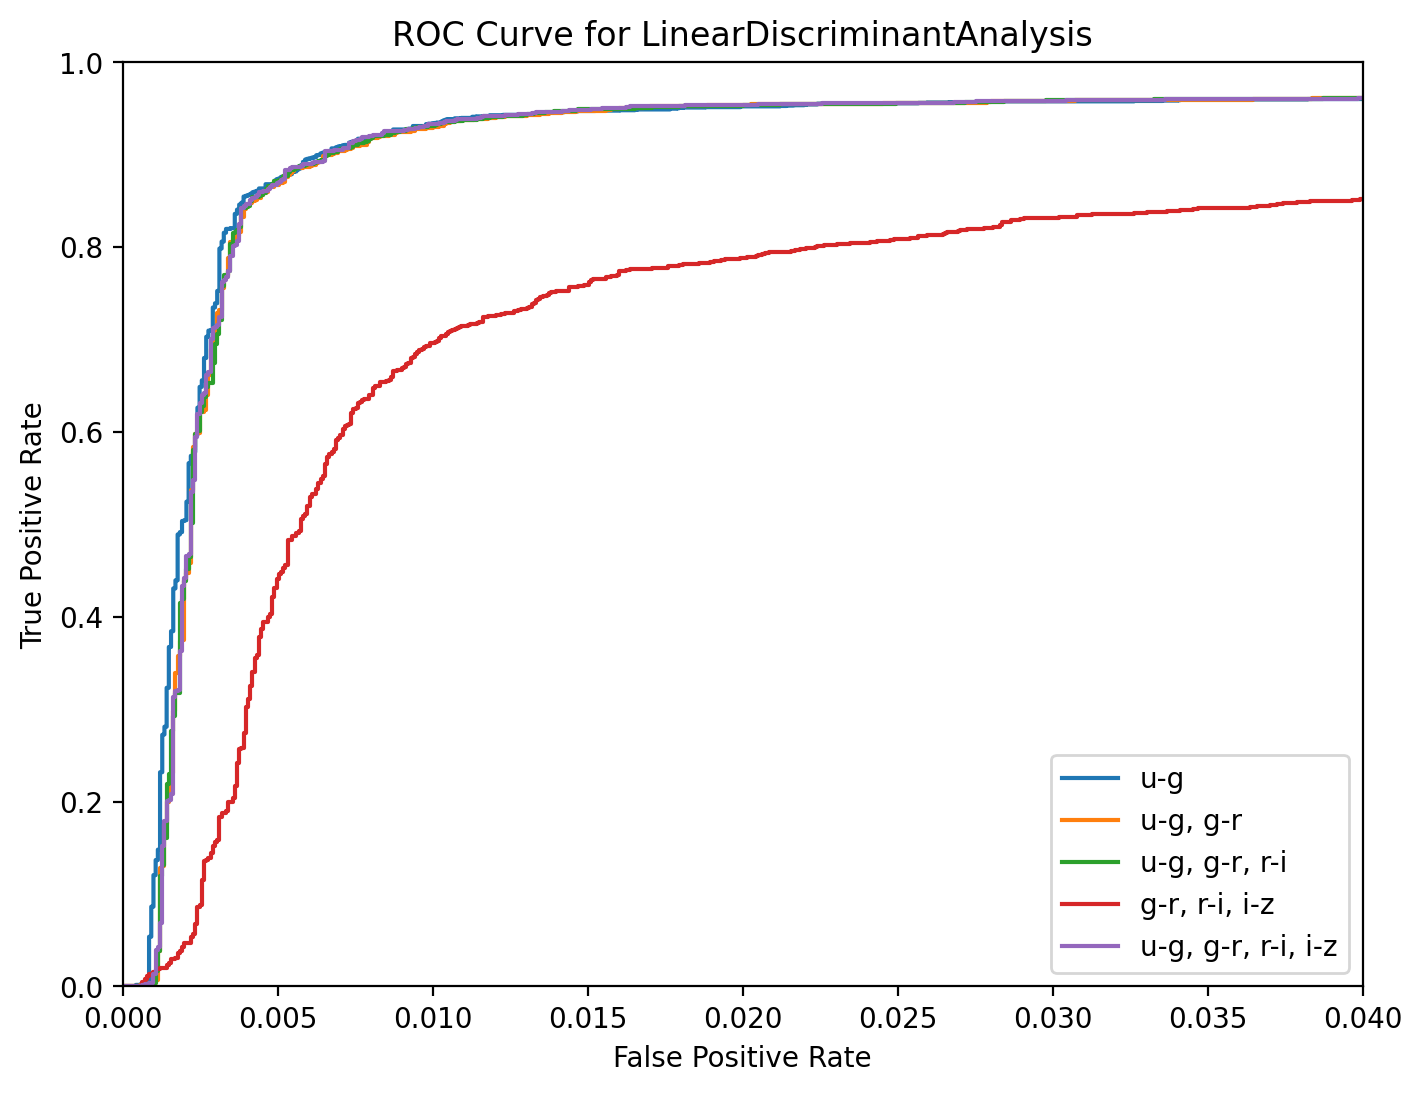

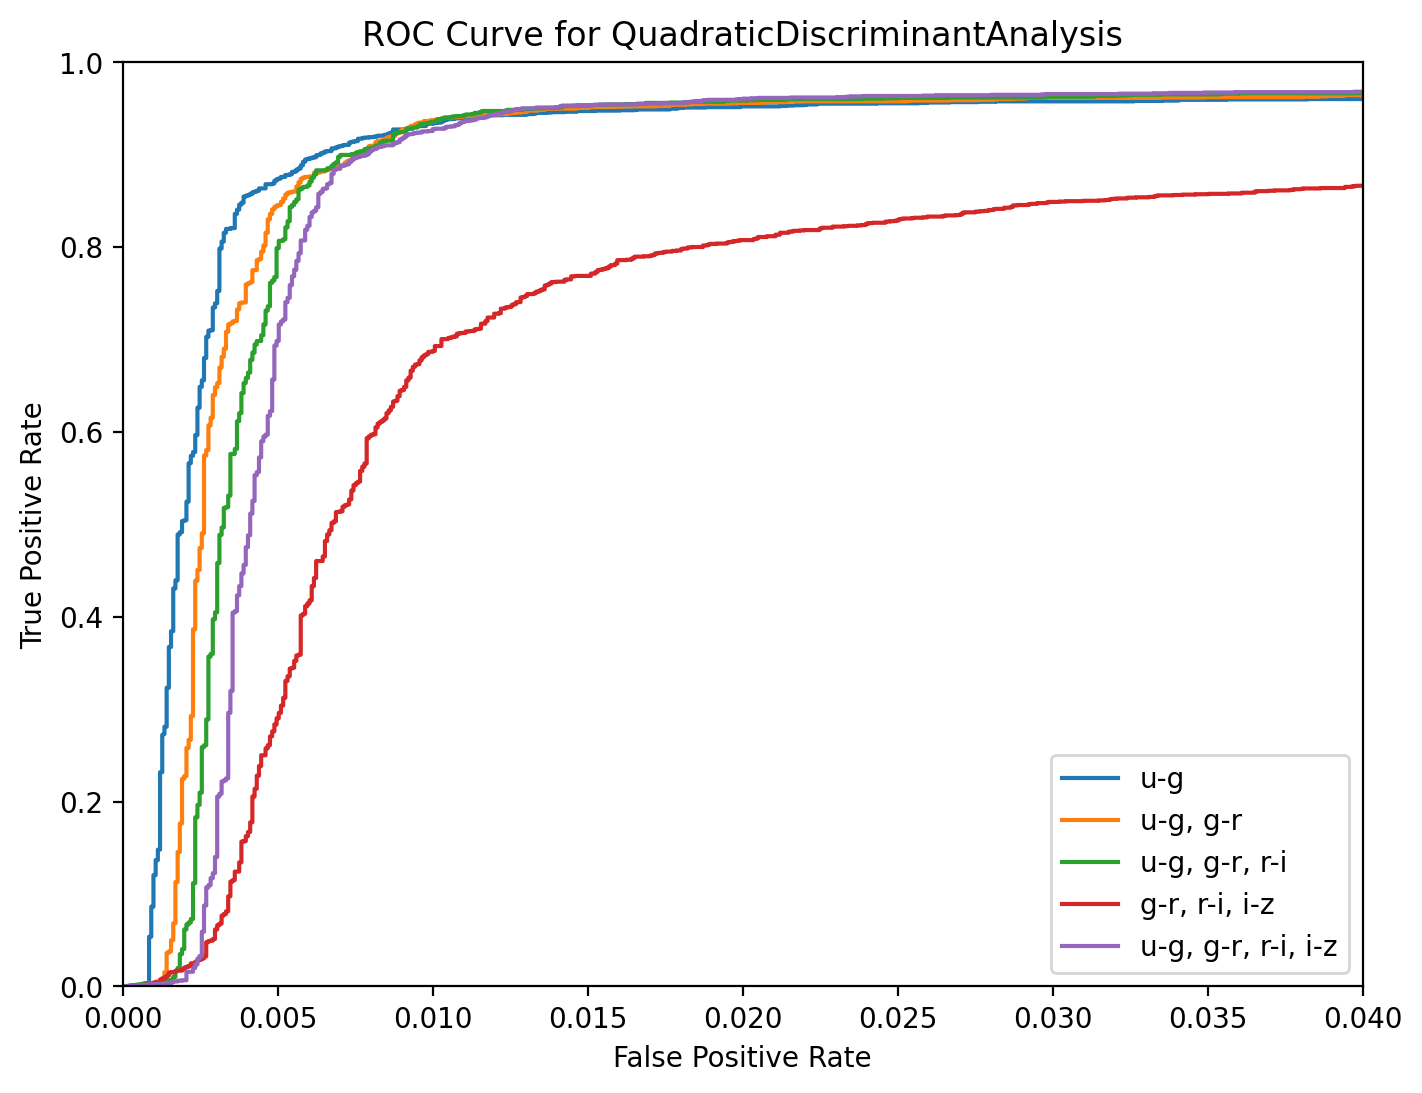

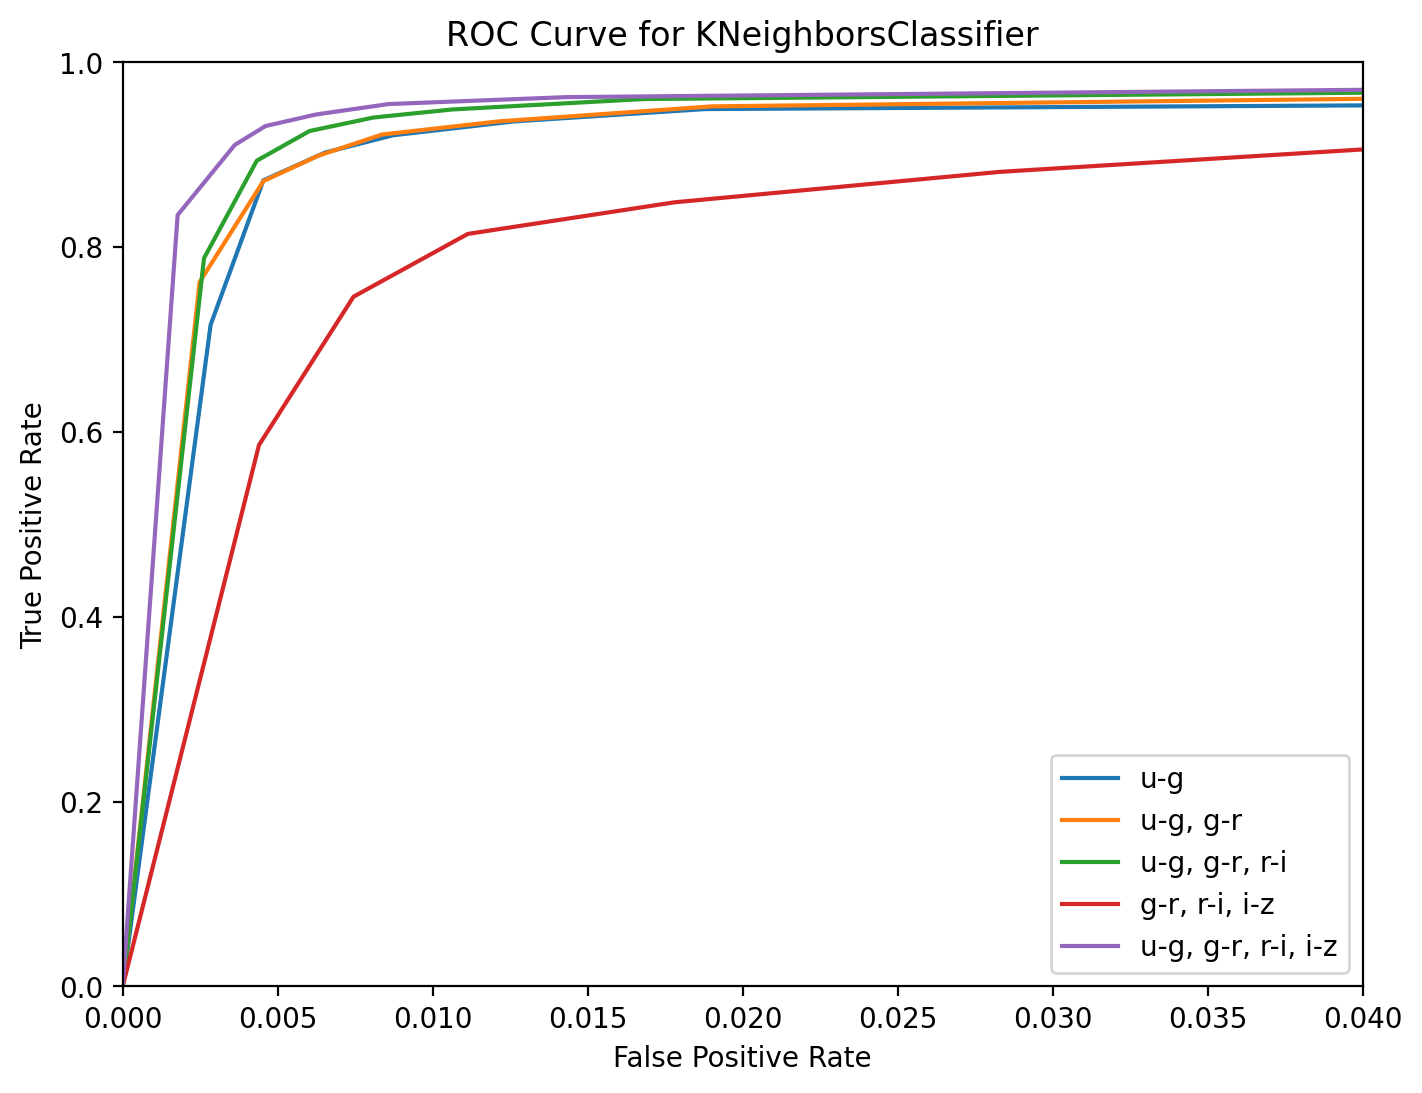

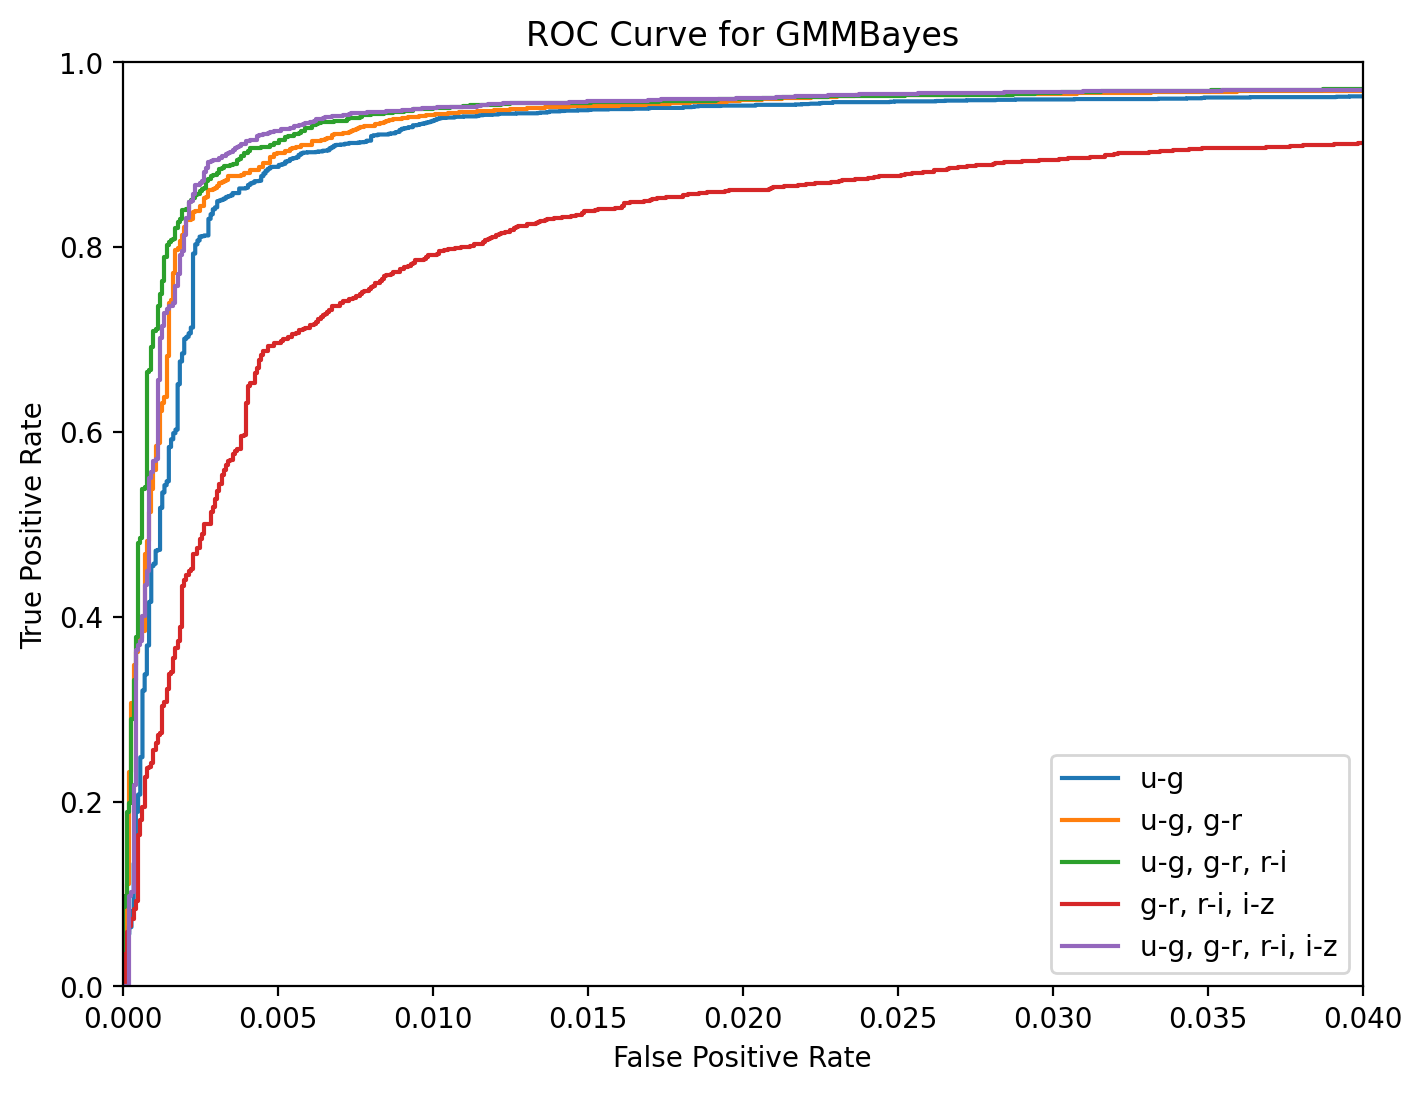

In [69]:
# Iterate over each classifier and create a separate plot for each one
for classifier, kwargs in classifiers:
    plt.figure(figsize=(8, 6))
    plt.title(f"ROC Curve for {classifier.__name__}")

    # Iterate over each subset
    for subset_name, X_subset in subsets.items():
        # Train/test split for the subset
        X_train, X_test, y_train, y_test = train_test_split(X_subset, labels_01, test_size=0.33, random_state=42)

        # Initialize and fit classifier
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)

        # Get predicted probabilities
        y_probs = clf.predict_proba(X_test)[:, 1]

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_probs)

        # Add (0, 0) as the first point
        fpr = np.concatenate([[0], fpr])
        tpr = np.concatenate([[0], tpr])

        # Plot ROC curve for the subset
        plt.plot(fpr, tpr, label=f"{subset_name}")

    # Finalize plot for the current classifier
    plt.xlim(0, 0.04)
    plt.ylim(0, 1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right', fontsize=10)
    plt.show()  # Display each plot separately

In each case, we observe that the ROC curves for subsets with one, two, or three features—and for the full dataset—are very similar **as long as the most important feature (in this case, u-g) is included in the subset**. However, when we exclude u-g and use only the other three features, the resulting ROC curve is noticeably worse than the others.

#### Let's look at the Accuracy

In [70]:
acc_subsets = {
    'u-g': u_g.reshape(-1,1),
    'g-r': u_g.reshape(-1,1),
    'r-i': u_g.reshape(-1,1),
    'i-z': u_g.reshape(-1,1),
    'u-g, g-r': np.vstack([u_g, g_r]).T,
    'g-r, r-i': np.vstack([g_r, r_i]).T,
    'u-g, g-r,r-i': np.vstack([u_g, g_r, r_i]).T,
    'g-r, r-i, i-z': np.vstack([g_r, r_i, i_z]).T,
    'u-g, g-r, r-i, i-z': Dataset    
}

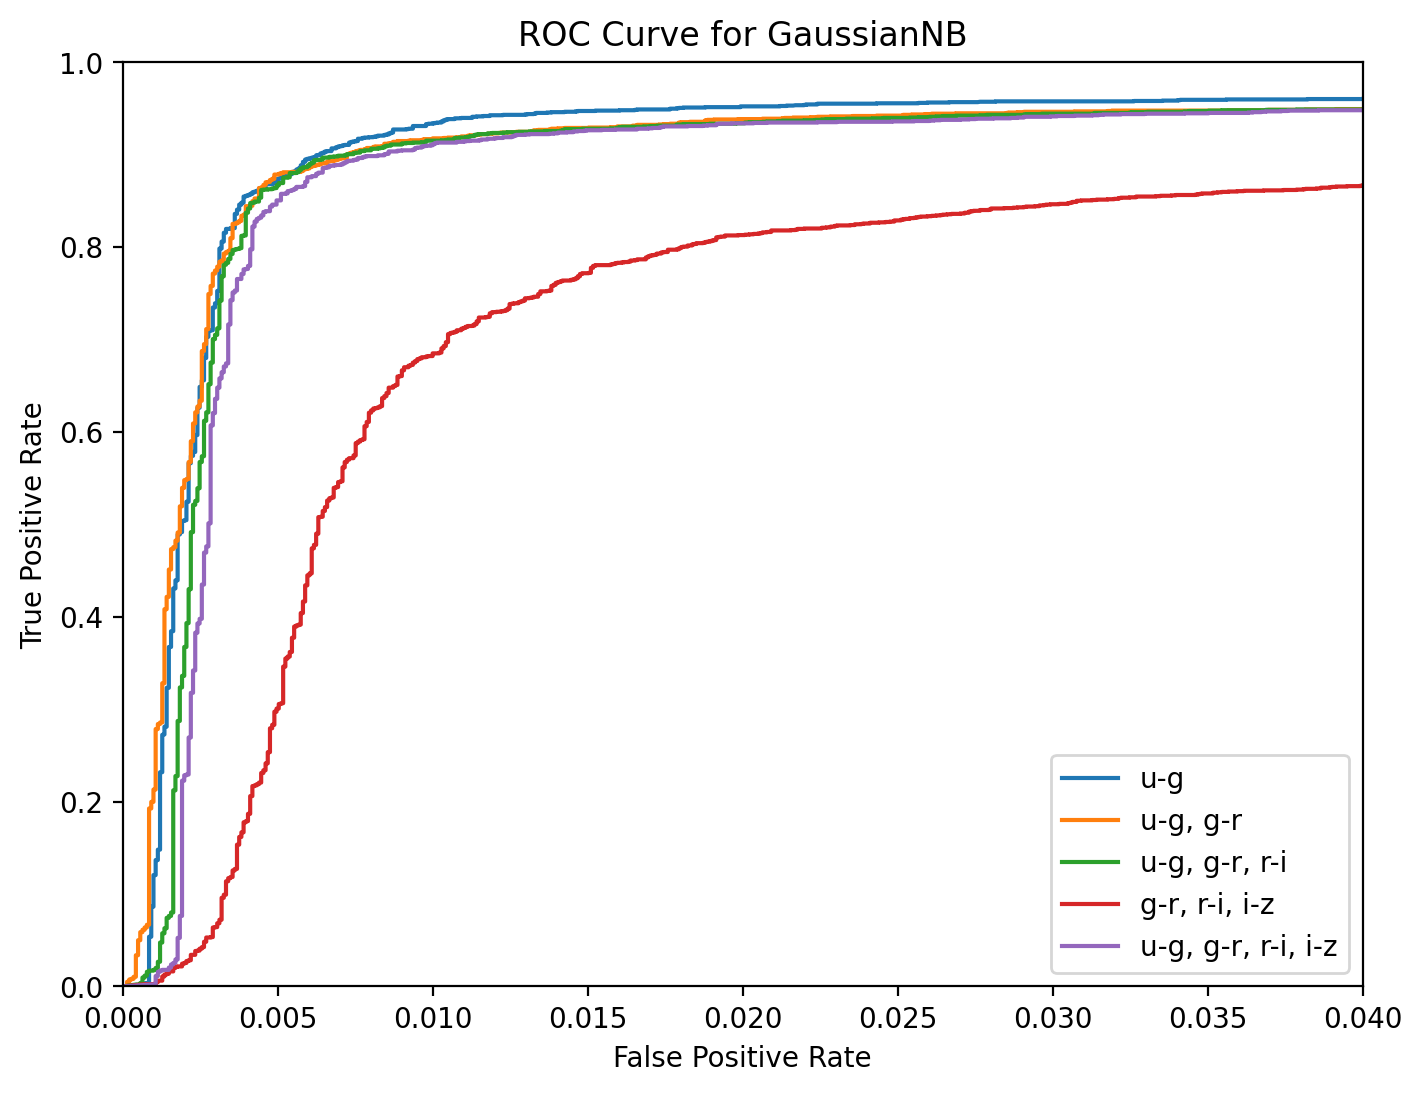

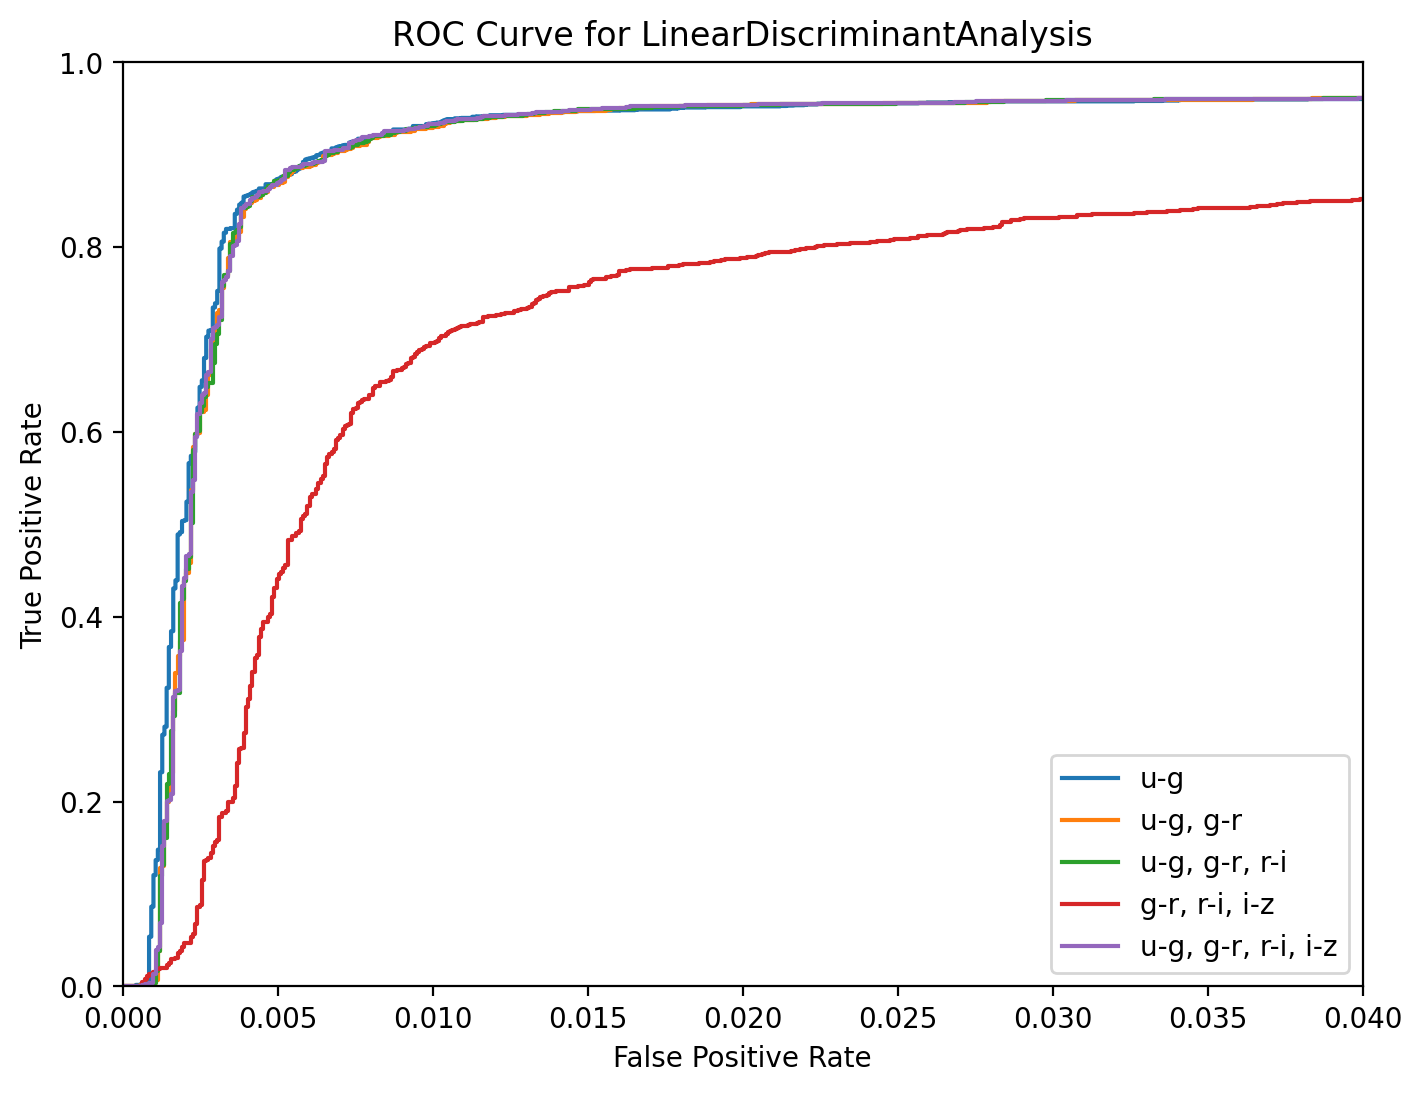

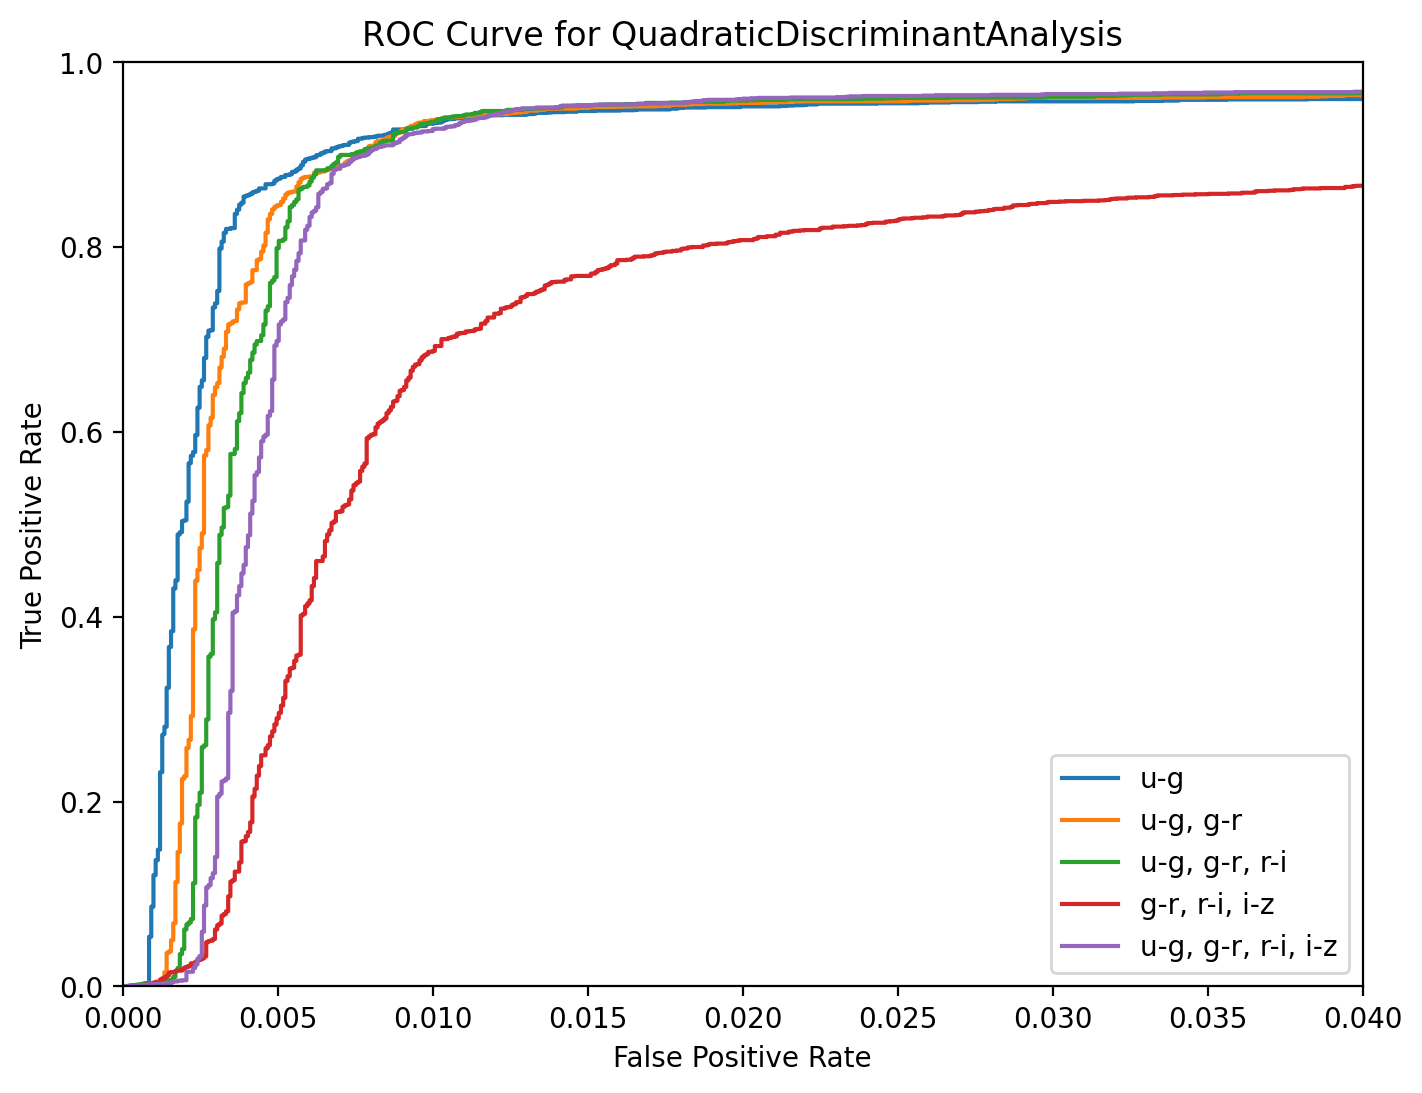

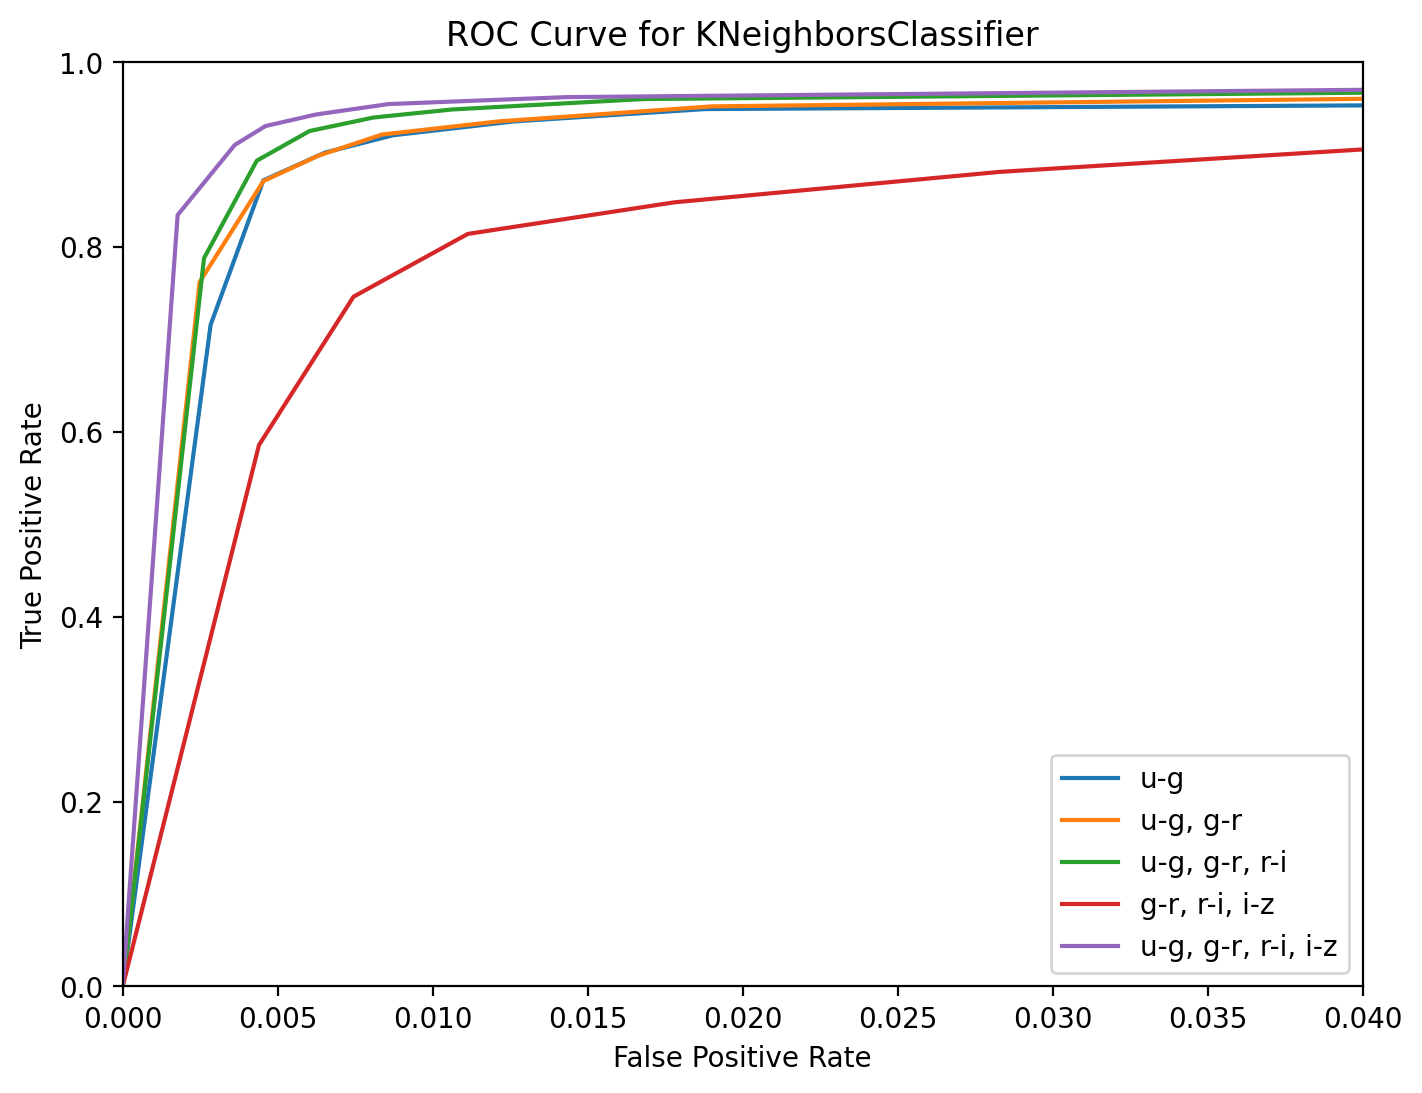

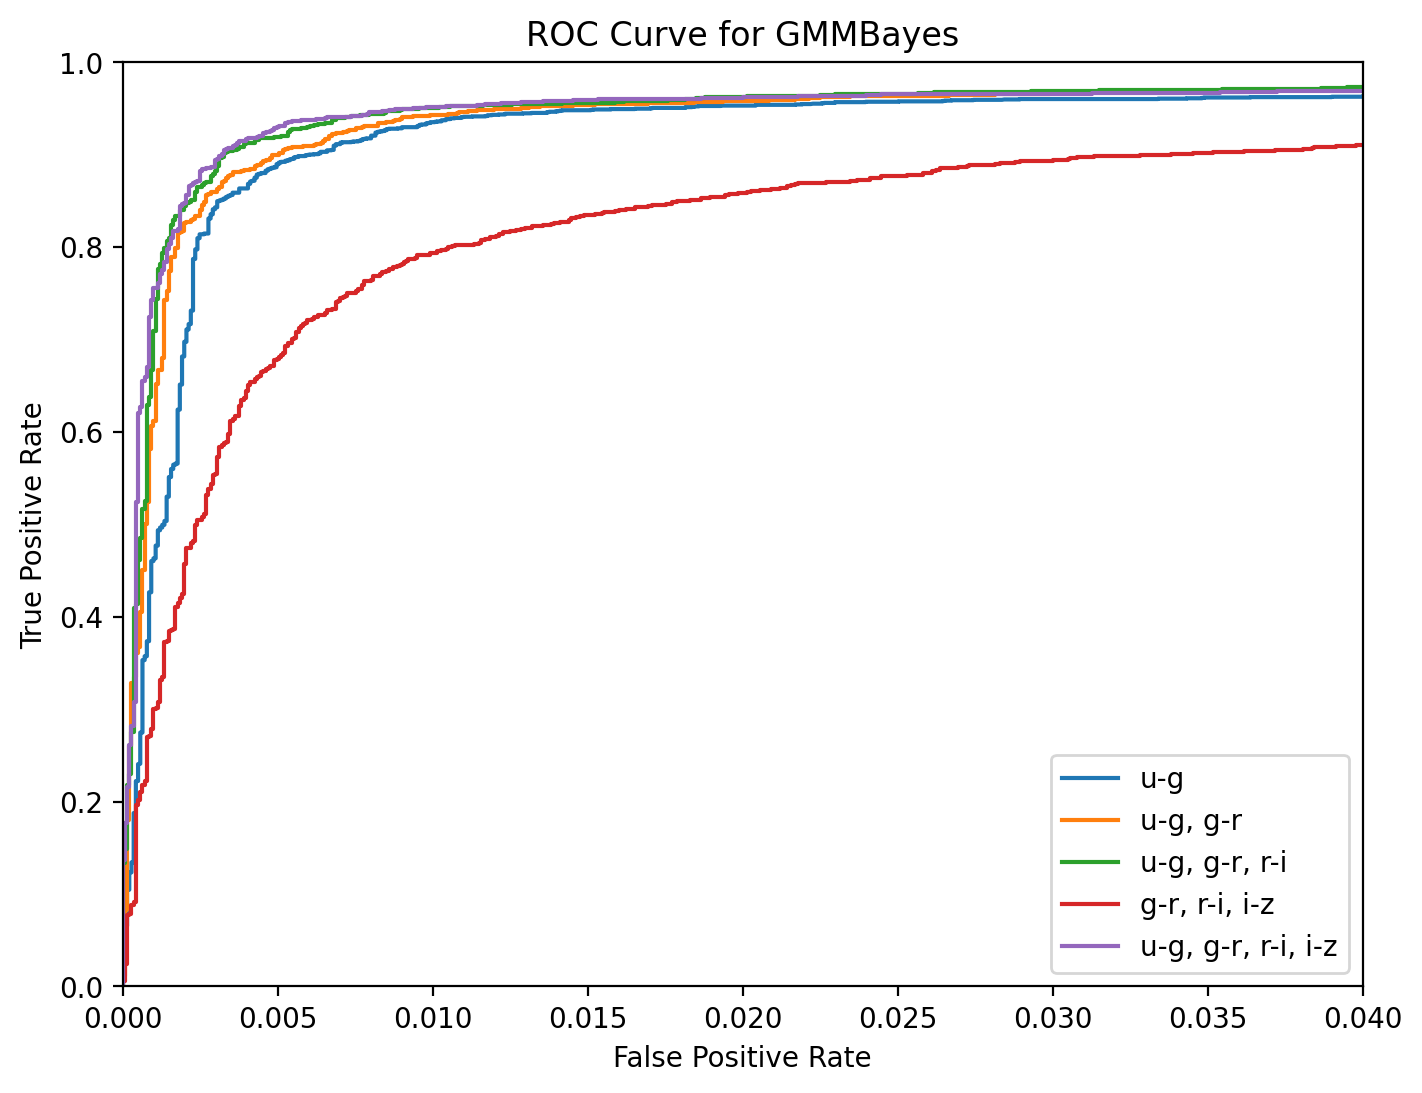

In [71]:
for classifier, kwargs in classifiers:
    plt.figure(figsize=(8, 6))
    plt.title(f"ROC Curve for {classifier.__name__}")

    # Iterate over each subset
    for subset_name, X_subset in subsets.items():
        # Train/test split for the subset
        X_train, X_test, y_train, y_test = train_test_split(X_subset, labels_01, test_size=0.33, random_state=42)

        # Initialize and fit classifier
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)

        # Get predicted probabilities
        y_probs = clf.predict_proba(X_test)[:, 1]

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_probs)

        # Add (0, 0) as the first point
        fpr = np.concatenate([[0], fpr])
        tpr = np.concatenate([[0], tpr])

        # Plot ROC curve for the subset
        plt.plot(fpr, tpr, label=f"{subset_name}")

    # Finalize plot for the current classifier
    plt.xlim(0, 0.04)
    plt.ylim(0, 1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right', fontsize=10)
    plt.show()  # Display each plot separately

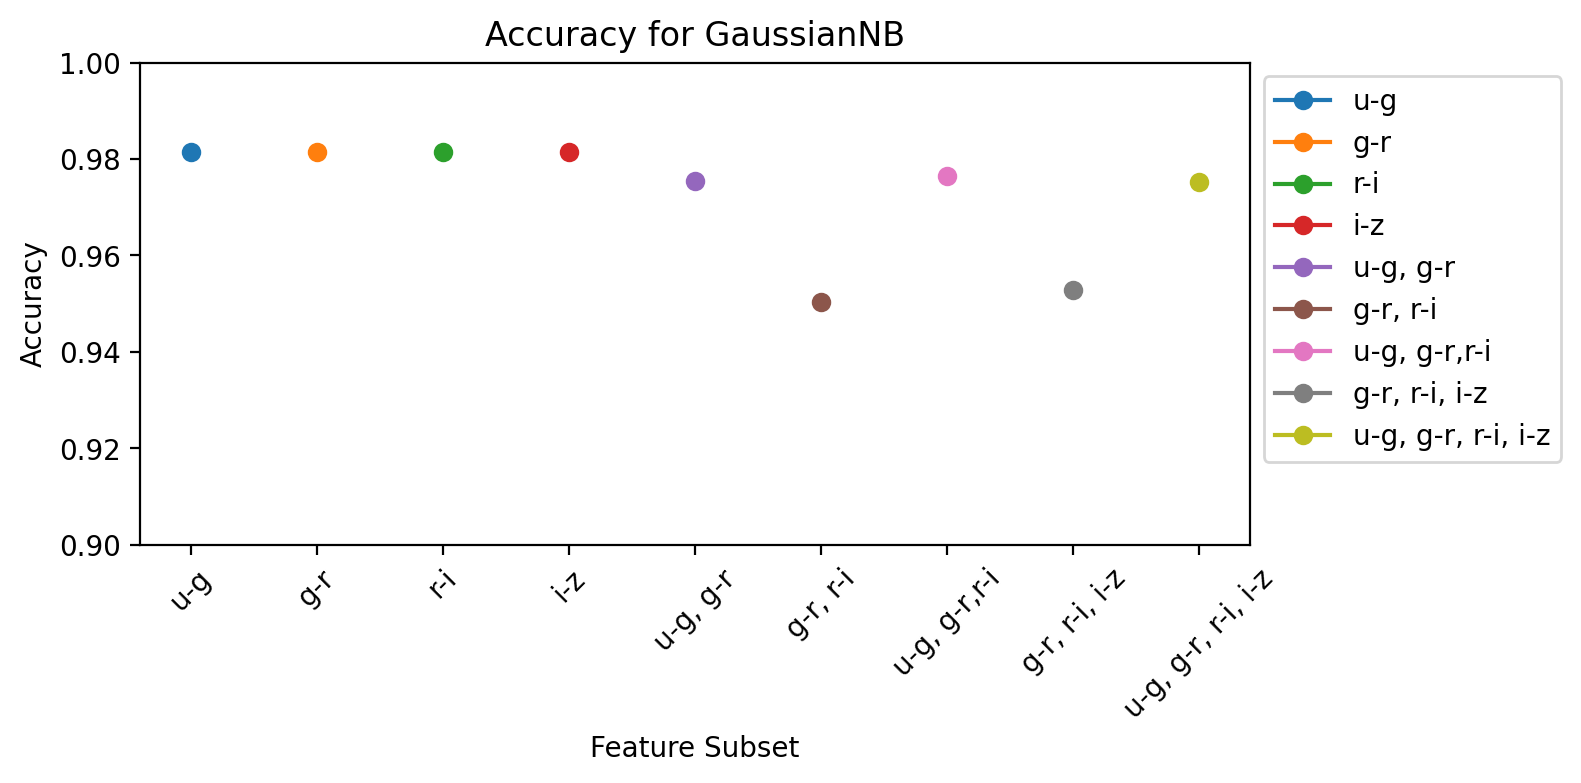

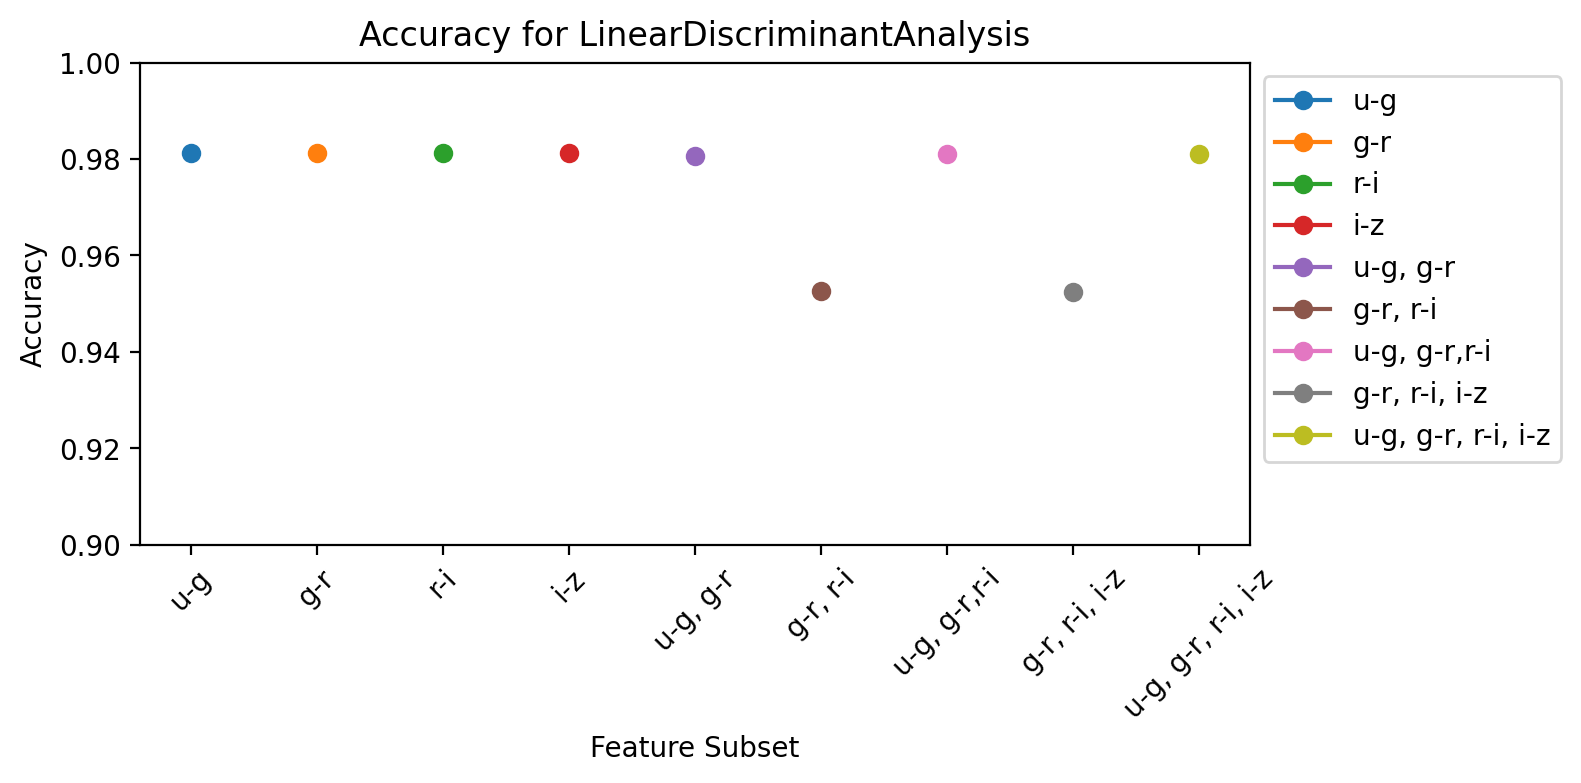

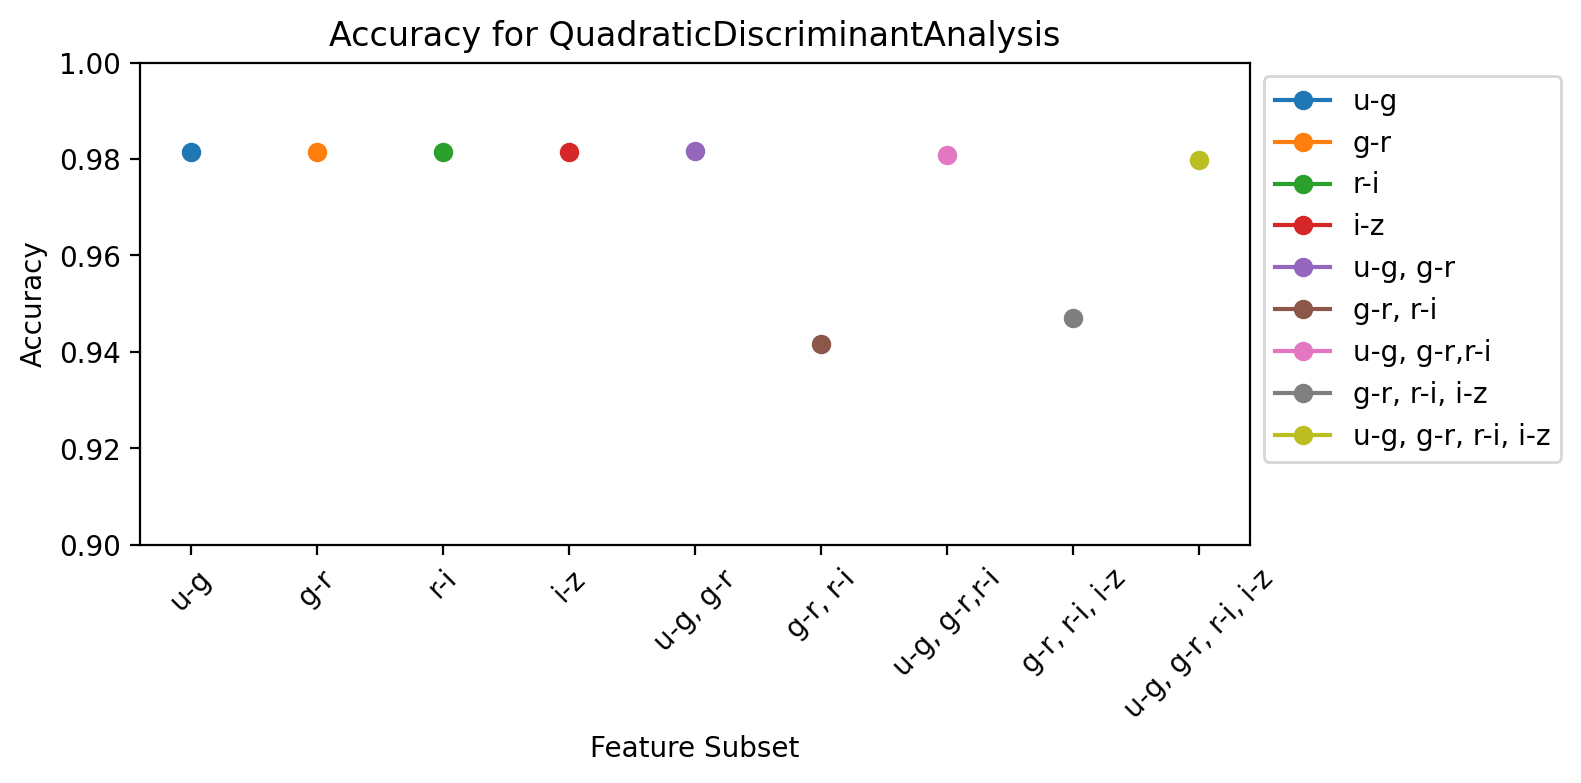

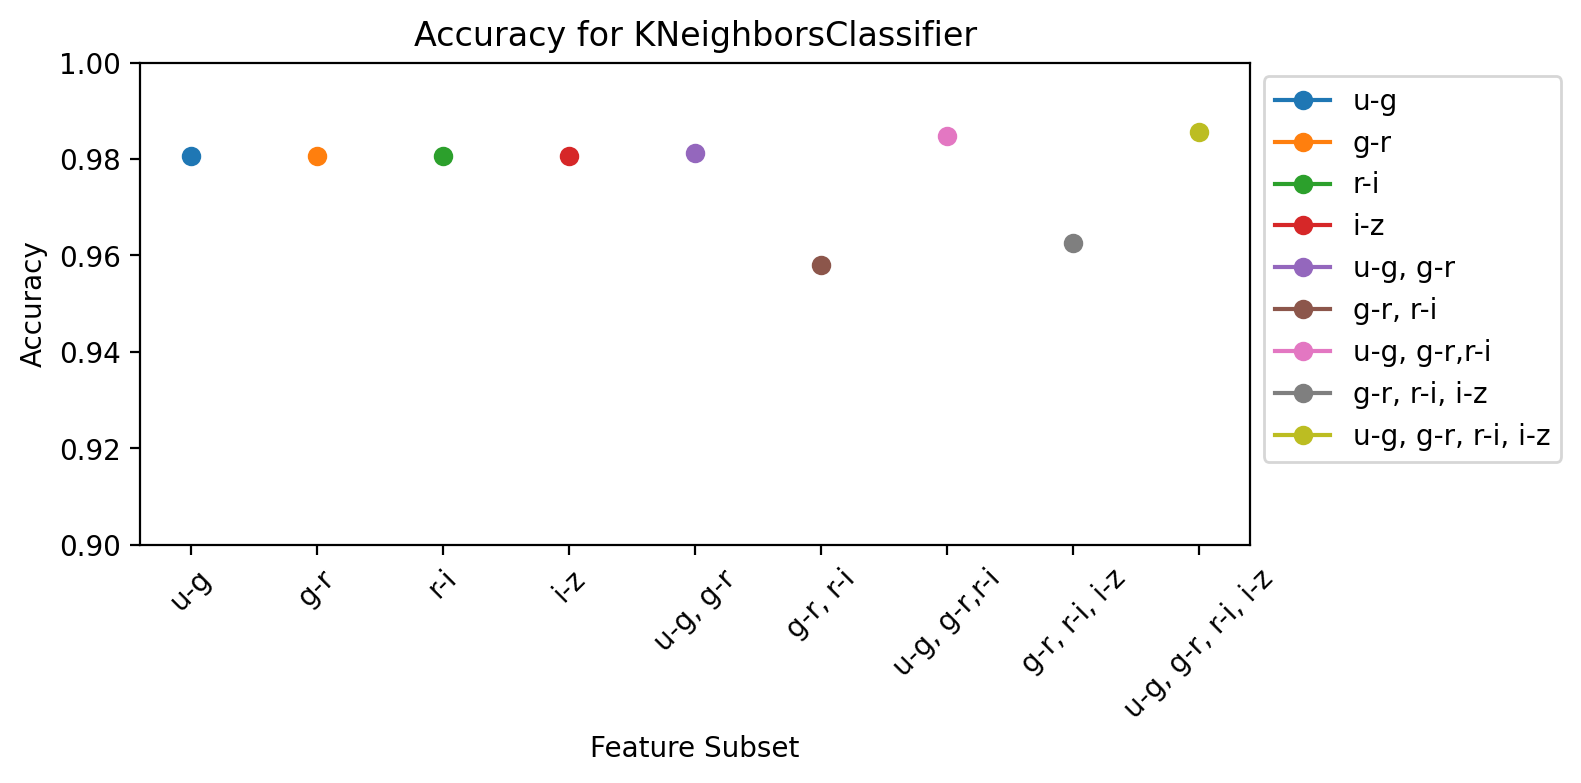

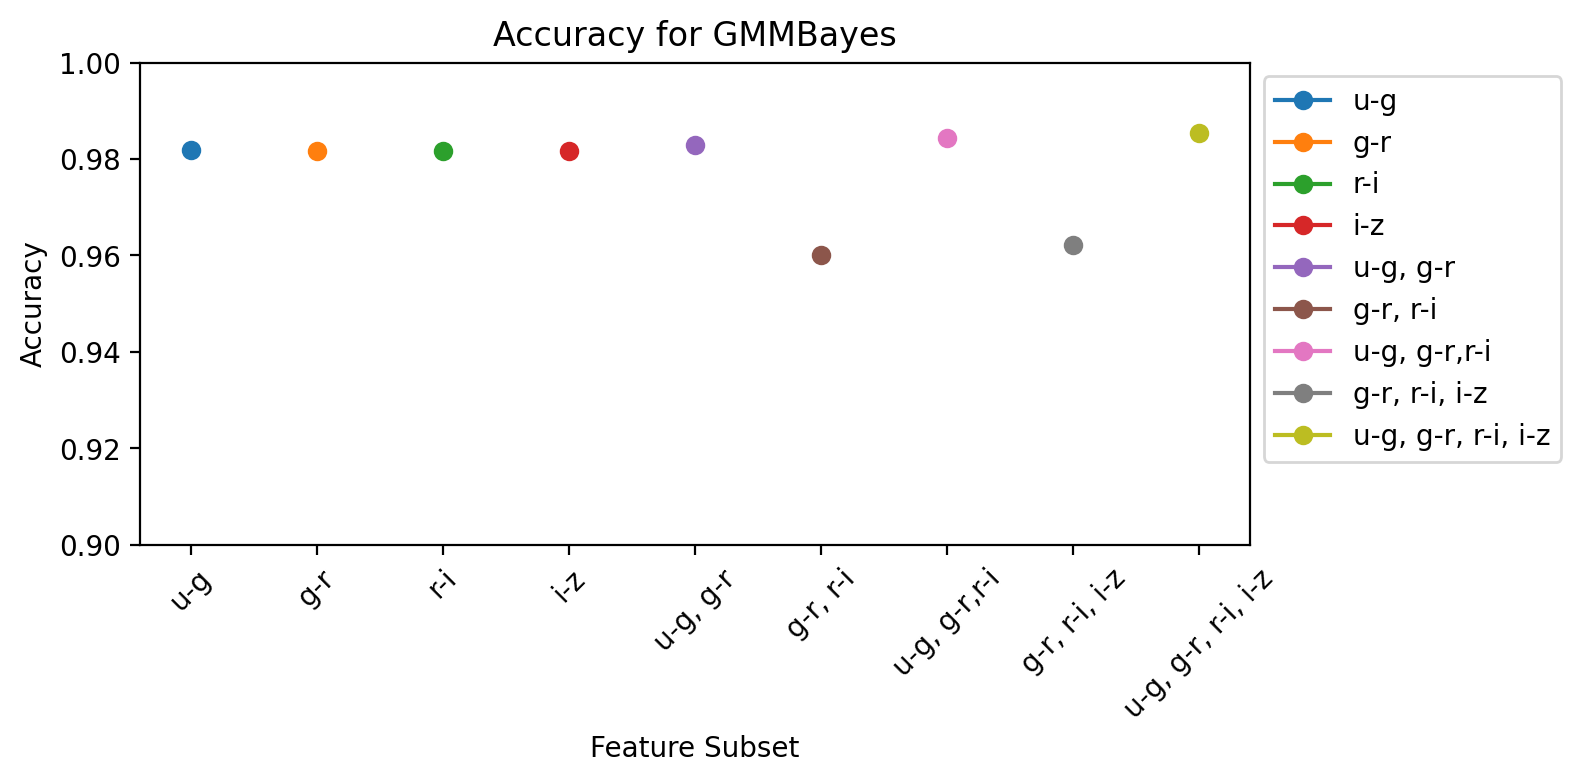

The most indicative subsets are:
GaussianNB: u-g
LinearDiscriminantAnalysis: u-g
QuadraticDiscriminantAnalysis: u-g, g-r
KNeighborsClassifier: u-g, g-r, r-i, i-z
GMMBayes: u-g, g-r, r-i, i-z


In [72]:
results = {}


# Iterate on each classifier
for classifier, kwargs in classifiers:
    plt.figure(figsize=(8, 4))
    plt.title(f"Accuracy for {classifier.__name__}")  # Titolo corretto

    # Iterate on each subset
    for subset_name, X_subset in acc_subsets.items():
        # print(f"Training on subset: {subset_name} for classifier: {classifier.__name__}")  # Debugging

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(X_subset, labels_01, test_size=0.3, random_state=42)

        # Iniitialize and train classifier
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        
        # accuracy calculation
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        # Add results
        if classifier.__name__ not in results:
            results[classifier.__name__] = {}
        results[classifier.__name__][subset_name] = accuracy
        
        # Accuracy plot
        plt.plot(subset_name, accuracy, marker='o', linestyle='-', label=f'{subset_name}')

    
    plt.xlabel('Feature Subset')
    plt.ylabel('Accuracy')
    plt.ylim(0.9, 1.0)
    plt.xticks(rotation=45)

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Riduci l'area del grafico per fare spazio alla legenda

    
    plt.tight_layout()
    plt.show();

# Identifica il subset più indicativo per ciascun classificatore
most_indicative_subset = {}
for clf_name, clf_results in results.items():
    most_indicative_subset[clf_name] = max(clf_results, key=clf_results.get)

# Stampa il subset più indicativo
print("The most indicative subsets are:")
for clf_name, subset in most_indicative_subset.items():
    print(f"{clf_name}: {subset}")


## Try PCA 

In [73]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [74]:
scaler = StandardScaler()
X = scaler.fit_transform(ND_dataset)
pca = PCA()
pca.fit(X)

PCA()

In [75]:
eigenvalues  = pca.transform(X)
mean         = pca.mean_
eigenvectors = pca.components_
evals        = pca.explained_variance_ratio_

print(f'New Shape: {eigenvalues.shape}')
print(f'Explained fractional variance of data encapsulated in the eigenvalues: {evals}')

New Shape: (50000, 4)
Explained fractional variance of data encapsulated in the eigenvalues: [0.55399123 0.28934648 0.11321224 0.04345004]


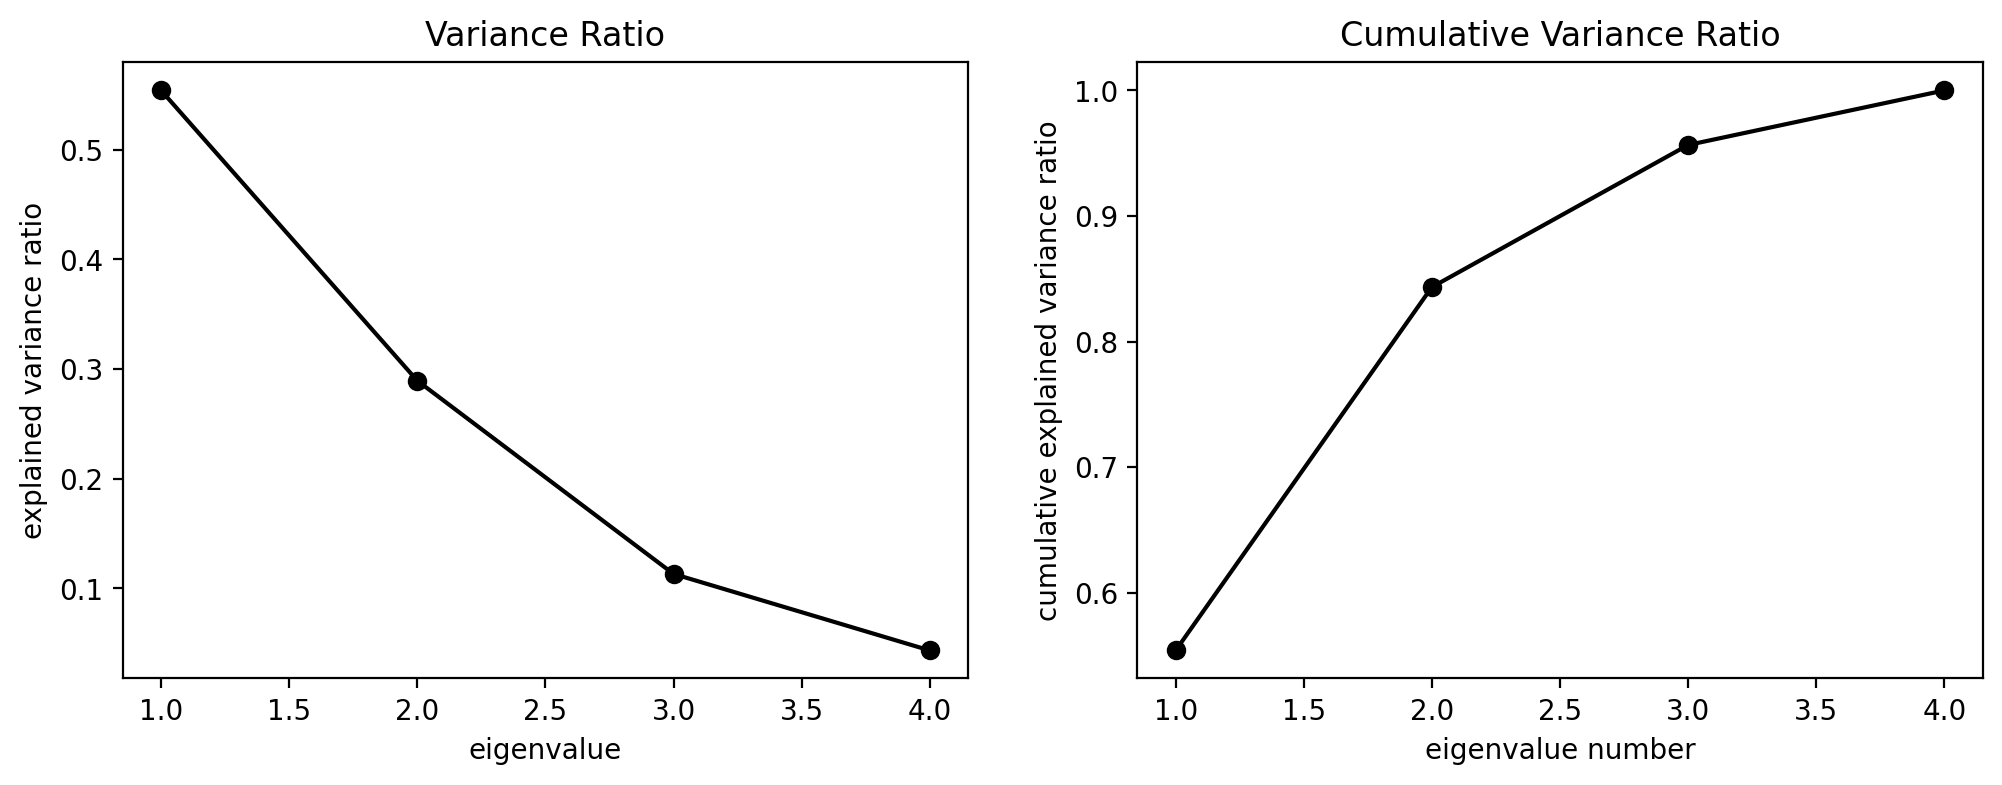

In [76]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)

n_components= np.ones(len(pca.explained_variance_ratio_ )) + range(len(pca.explained_variance_ratio_ ))

ax.plot(n_components, evals, color='black')
ax.scatter(n_components, evals, color='black')

ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")
ax.set_title('Variance Ratio')

ax = fig.add_subplot(122)

ax.plot(n_components, evals.cumsum(), color='black')
ax.scatter(n_components, evals.cumsum(), color='black')

ax.set_xlabel("eigenvalue number")
ax.set_ylabel("cumulative explained variance ratio")
ax.set_title('Cumulative Variance Ratio')

plt.show();

##### How many components should I keep?

Number of PCA components: 1, Accuracy: 0.972
Number of PCA components: 2, Accuracy: 0.967
Number of PCA components: 3, Accuracy: 0.965
Number of PCA components: 4, Accuracy: 0.974


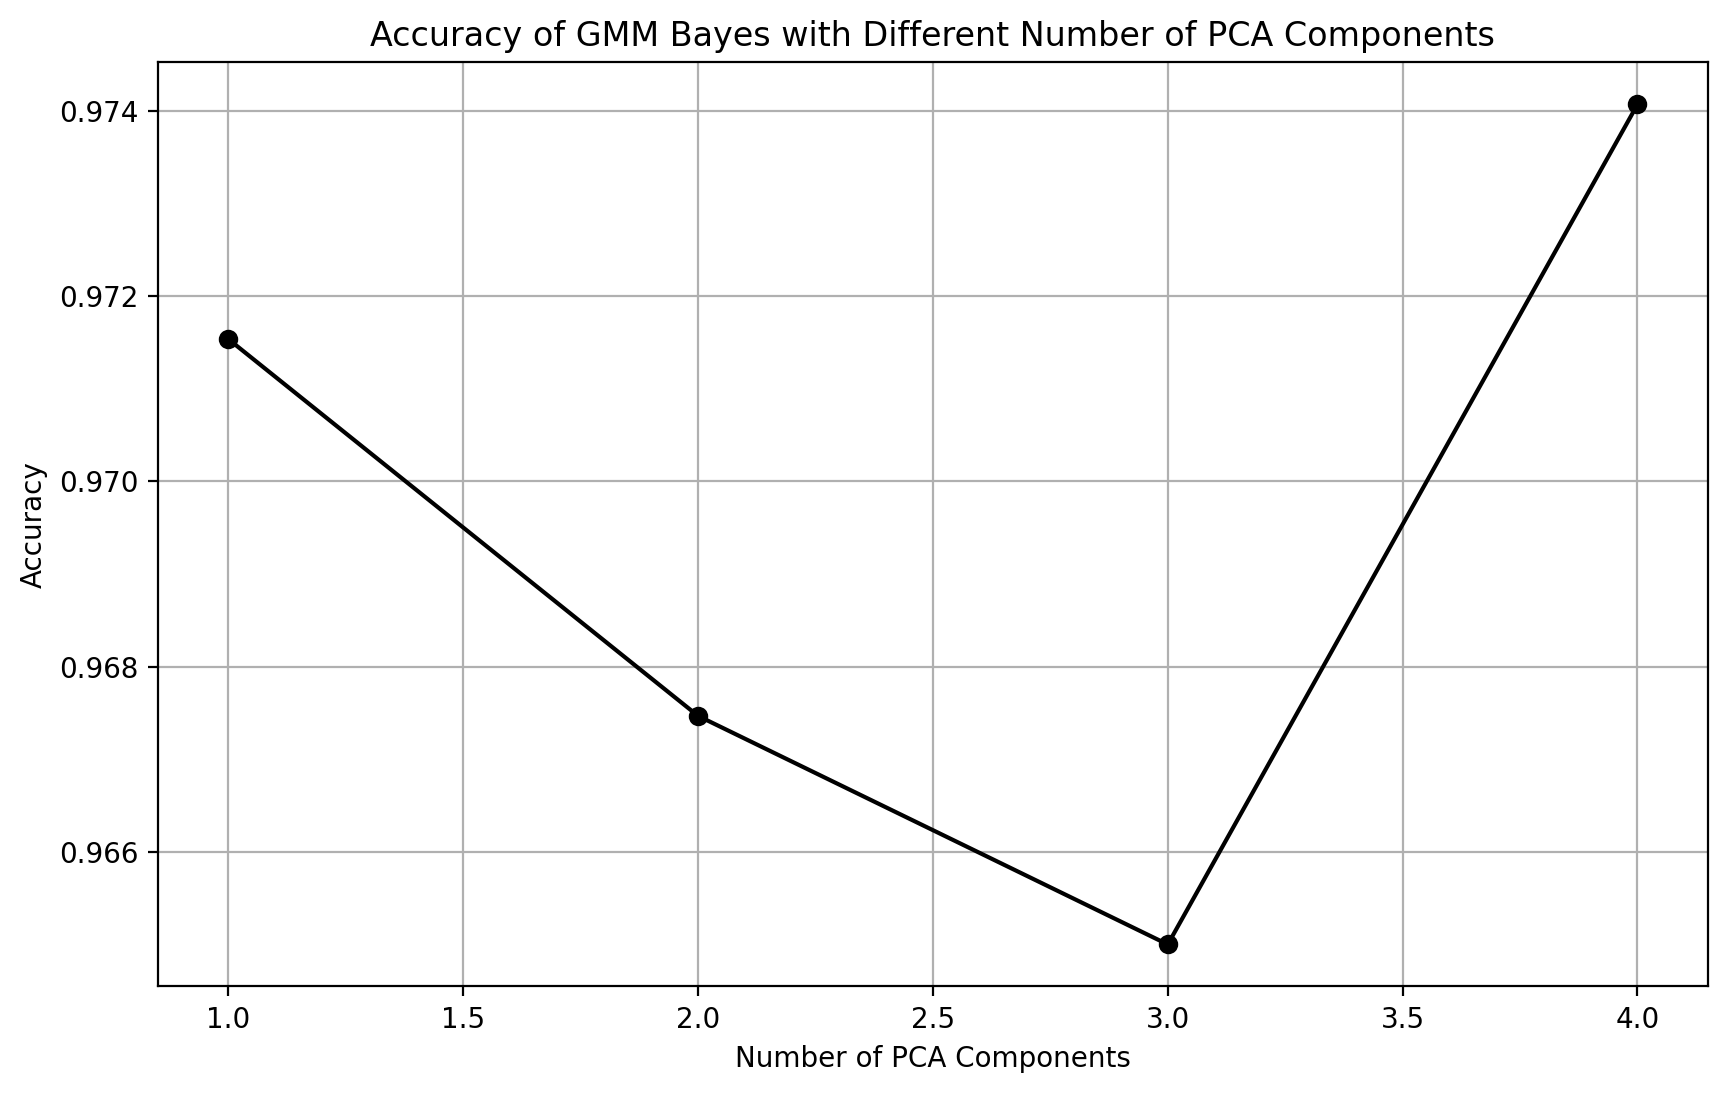

In [77]:
# Evaluate classification with GMM Bayes, changing the number of features
n_components_list = [1, 2, 3, 4]
results = {}

for n_components in n_components_list:
    X_pca_subset = eigenvalues[:, :n_components]
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca_subset, labels_01, test_size=0.3, random_state=42)
    
    gmm_bayes = GMMBayes(n_components=3)
    gmm_bayes.fit(X_train_pca, y_train_pca)
    
    y_pred_pca = gmm_bayes.predict(X_test_pca)
    accuracy = accuracy_score(y_test_pca, y_pred_pca)
    results[n_components] = accuracy
    print(f"Number of PCA components: {n_components}, Accuracy: {accuracy:.3f}")

# Plot the accuracy for different number of PCA components
plt.figure(figsize=(10, 6))
plt.plot(list(results.keys()), list(results.values()), marker='o', color='black')
plt.title('Accuracy of GMM Bayes with Different Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()